## Imports


In [305]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

#MLFLOW
import mlflow
mlflow.autolog()

2023/12/21 15:35:31 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2023/12/21 15:35:31 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/12/21 15:35:31 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2023/12/21 15:35:31 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


## Données  


In [306]:
# List files available
print(os.listdir("raw_data"))

['application_train.csv']


In [307]:
# Training data
app_train = pd.read_csv('raw_data/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


307511 observations et 122 features (variables) incluants la `TARGET` (étiquette à predire).

In [308]:
app_train = app_train.sample(frac =.20)
app_train.shape

(61502, 122)

In [309]:
labels = app_train['TARGET']

In [310]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(app_train, labels, shuffle=True, train_size=0.8, random_state=42)
print(f"Nous avons X_train de forme {X_train.shape} et y_train de forme {y_train.shape}")
print(f"Nous avons X_temp de forme {X_temp.shape} et y_temp de forme {y_temp.shape}")

Nous avons X_train de forme (49201, 122) et y_train de forme (49201,)
Nous avons X_temp de forme (12301, 122) et y_temp de forme (12301,)


In [311]:
X_test, X_valid, y_test, y_valid = train_test_split(X_temp, y_temp, shuffle=False, test_size=0.5, random_state=42) #ici
#on ne touchera pas a la partie validation du dataset, seulement à la toute fin
print(f"Nous avons X_test de forme {X_test.shape} et y_test de forme {y_test.shape}")
X_valid = X_valid.drop(X_valid.index[[0]])
y_valid = y_valid.drop(X_valid.index[[0]])
print(f"Nous avons X_valid de forme {X_valid.shape} et y_valid de forme {y_valid.shape}")

Nous avons X_test de forme (6150, 122) et y_test de forme (6150,)
Nous avons X_valid de forme (6150, 122) et y_valid de forme (6150,)


# Analyse exploratoire de données

## Distribution de la cible
0 pour un pret remboursé à temps et 1 pour un client avec difficultés de paiments.

In [312]:
y_train.value_counts()

TARGET
0    45306
1     3895
Name: count, dtype: int64

In [313]:
from numpy import bincount

49201 / 3922

12.544875063742989

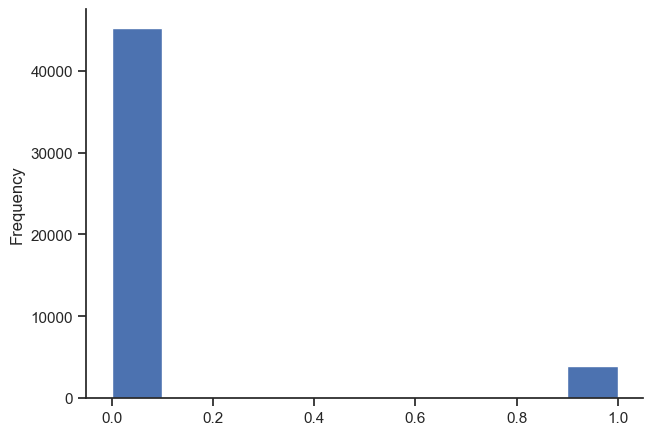

In [314]:
y_train.astype(int).plot.hist();

## NaN

<Axes: >

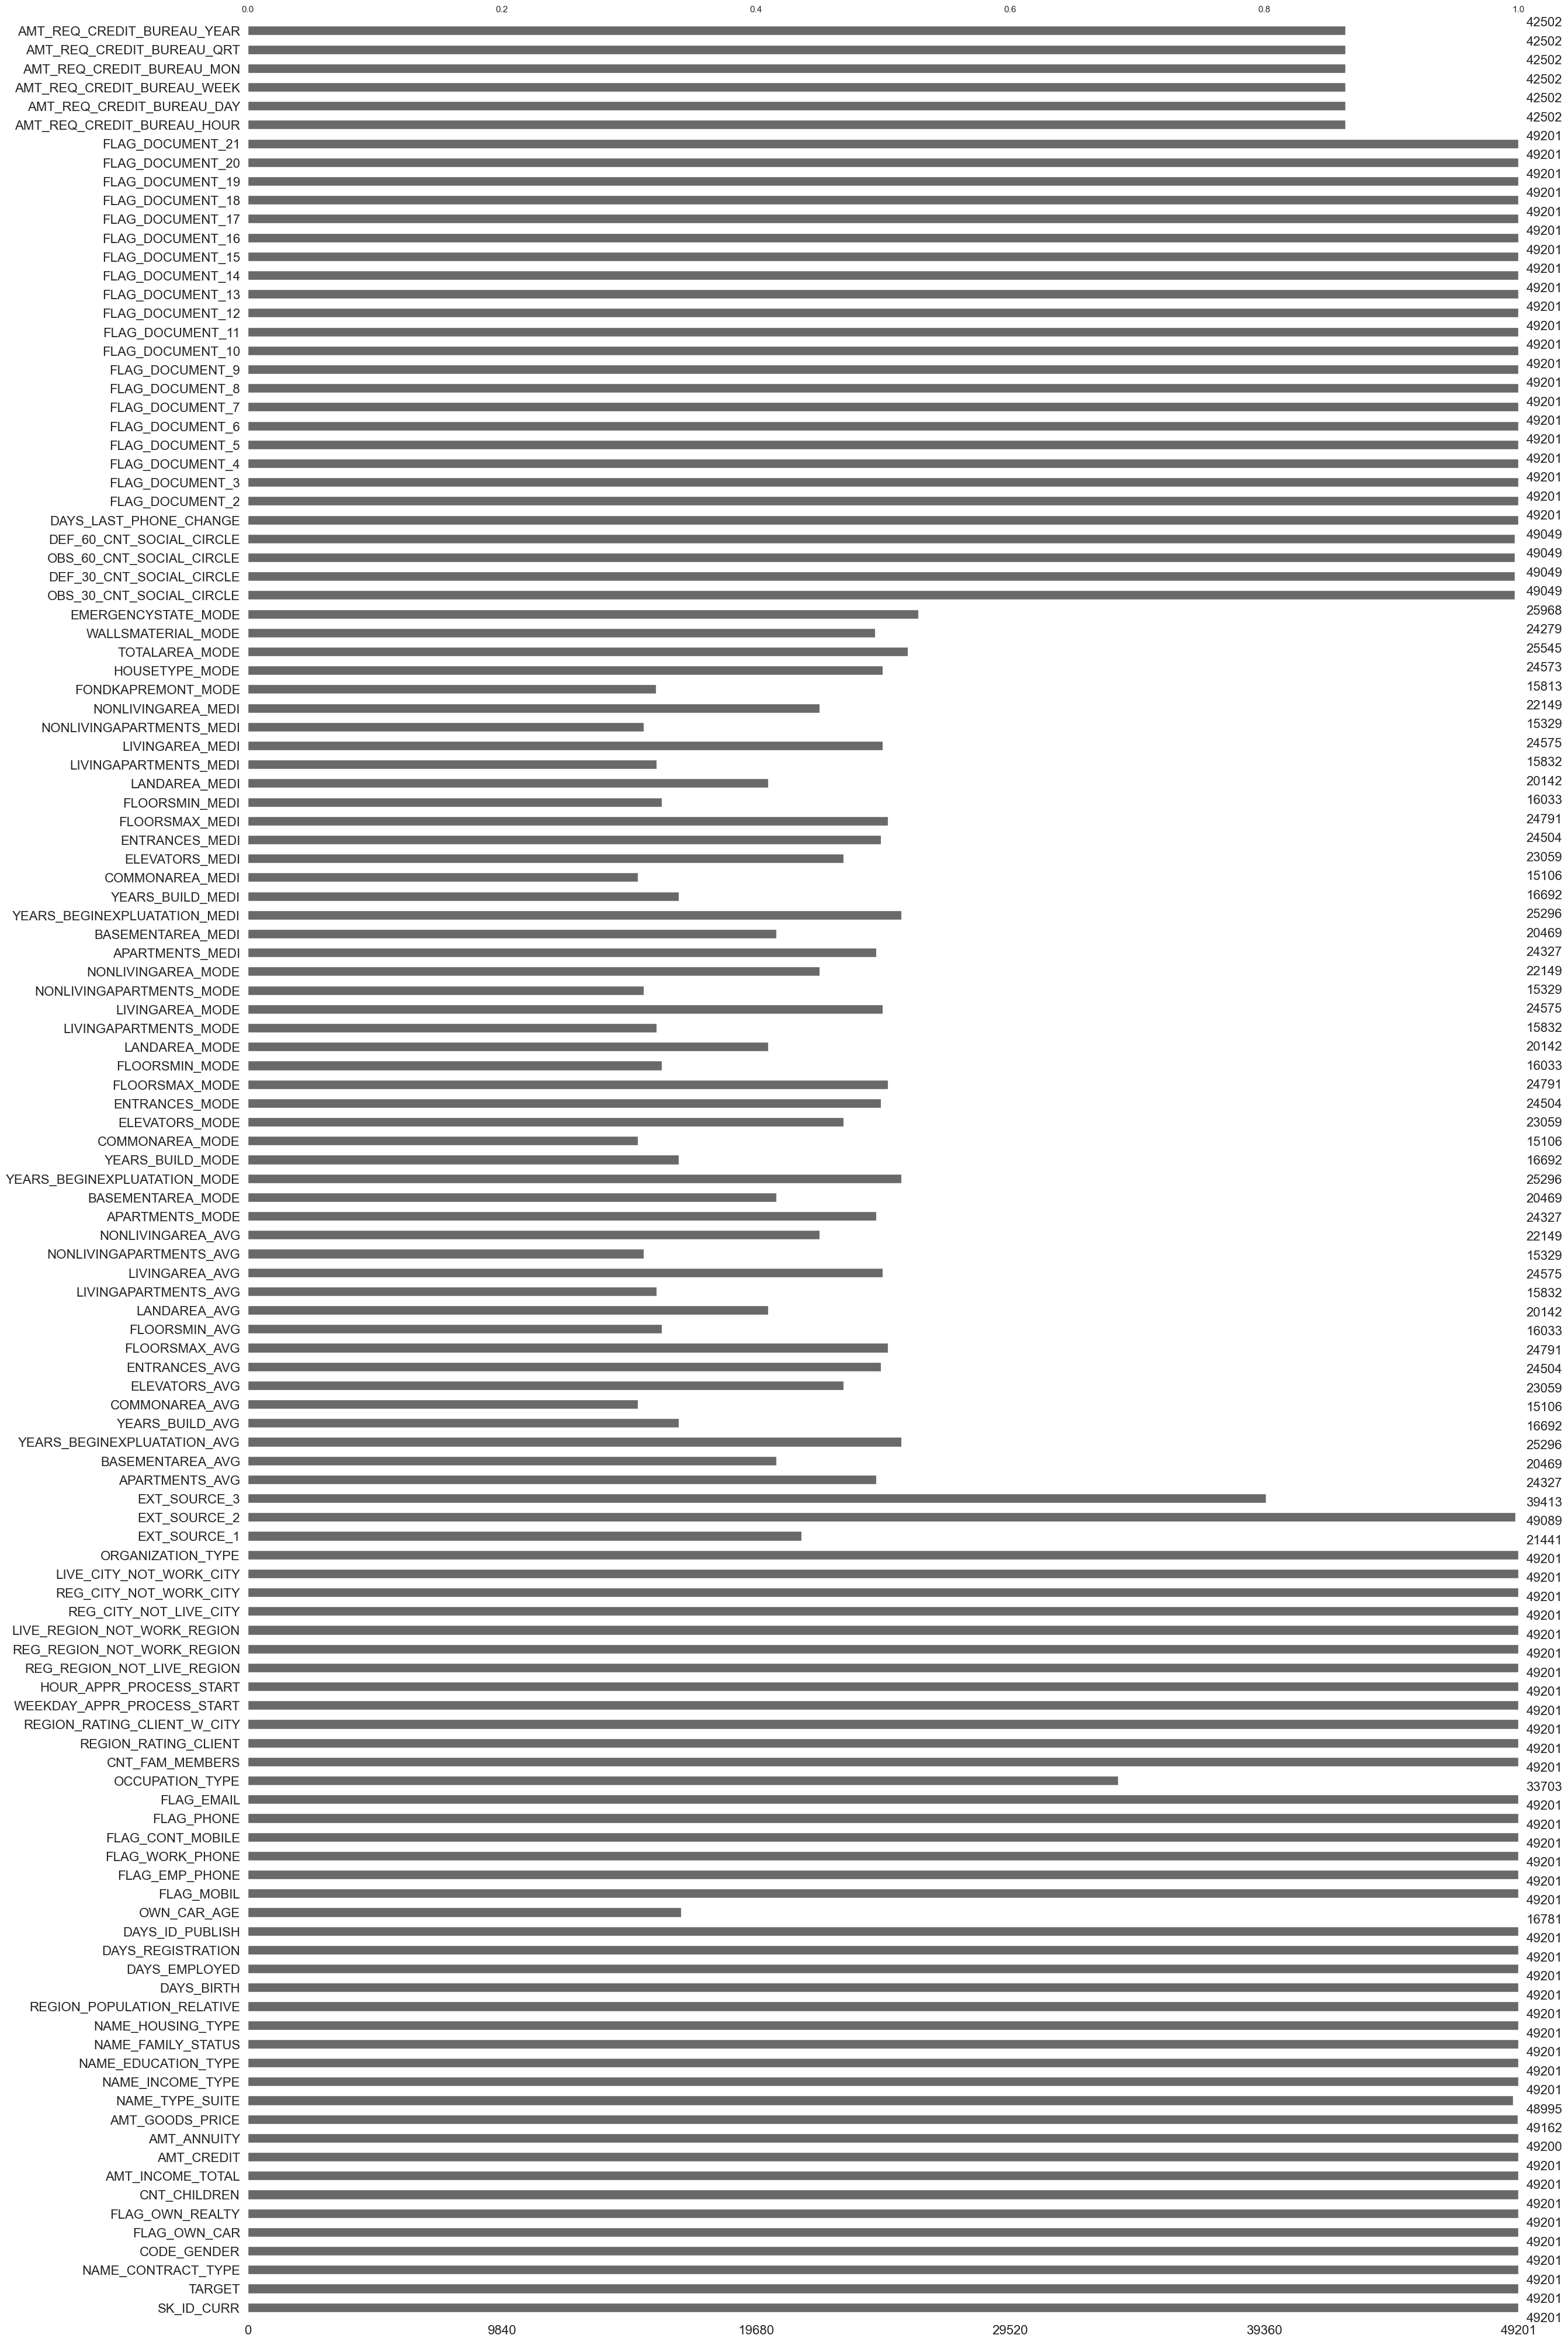

In [315]:
import missingno as msn
msn.bar(X_train)

## Types des colonnes

In [316]:
# Number of each type of column
X_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [317]:
# Number of unique classes in each object column
X_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [318]:
print(X_train['DAYS_EMPLOYED'].describe(),
X_test['DAYS_EMPLOYED'].describe(),
X_valid['DAYS_EMPLOYED'].describe())

count     49201.000000
mean      64706.725554
std      142024.078686
min      -16632.000000
25%       -2761.000000
50%       -1202.000000
75%        -283.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64 count      6150.000000
mean      61394.713496
std      139240.339744
min      -15882.000000
25%       -2798.750000
50%       -1243.500000
75%        -307.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64 count      6150.000000
mean      64697.130081
std      142001.777728
min      -16360.000000
25%       -2757.750000
50%       -1208.000000
75%        -273.250000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64


In [319]:
X_train['DAYS_EMPLOYED'] = abs(X_train['DAYS_EMPLOYED'])
X_test['DAYS_EMPLOYED'] = abs(X_test['DAYS_EMPLOYED'])
X_valid['DAYS_EMPLOYED'] = abs(X_valid['DAYS_EMPLOYED'])

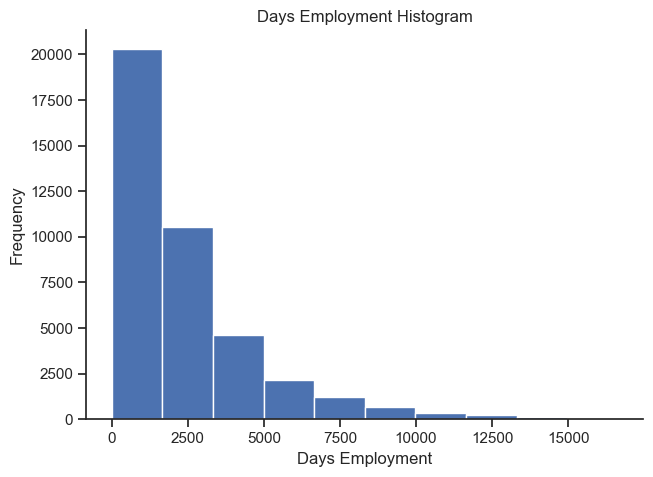

In [320]:
# Create an anomalous flag column
X_train['DAYS_EMPLOYED_ANOM'] = X_train["DAYS_EMPLOYED"] == 365243
X_test['DAYS_EMPLOYED_ANOM'] = X_test["DAYS_EMPLOYED"] == 365243
X_valid['DAYS_EMPLOYED_ANOM'] = X_valid["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
X_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
X_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)
X_valid["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

X_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [321]:
(X_train['DAYS_BIRTH'] / -365).describe()
(X_test['DAYS_BIRTH'] / -365).describe()
(X_valid['DAYS_BIRTH'] / -365).describe()

count    6150.000000
mean       43.880994
std        11.982660
min        21.068493
25%        33.872603
50%        42.991781
75%        53.949315
max        69.019178
Name: DAYS_BIRTH, dtype: float64

In [322]:
# Find the correlation of the positive days since birth and target
X_train['DAYS_BIRTH'] = abs(X_train['DAYS_BIRTH'])
X_test['DAYS_BIRTH'] = abs(X_test['DAYS_BIRTH'])
X_valid['DAYS_BIRTH'] = abs(X_valid['DAYS_BIRTH'])
X_train['DAYS_BIRTH'].corr(X_train['TARGET'])

-0.0814564822198675

### Effet de l'age sur le remboursement

Plus le client est âgé, plus il existe une relation linéaire négative avec la cible, ce qui signifie que plus les clients sont âgés, plus ils ont tendance à rembourser leurs prêts à temps. 
Commençons par examiner cette variable. Tout d'abord, nous pouvons faire un histogramme de l'âge. L'axe des x sera exprimé en années pour rendre le graphique un peu plus compréhensible.

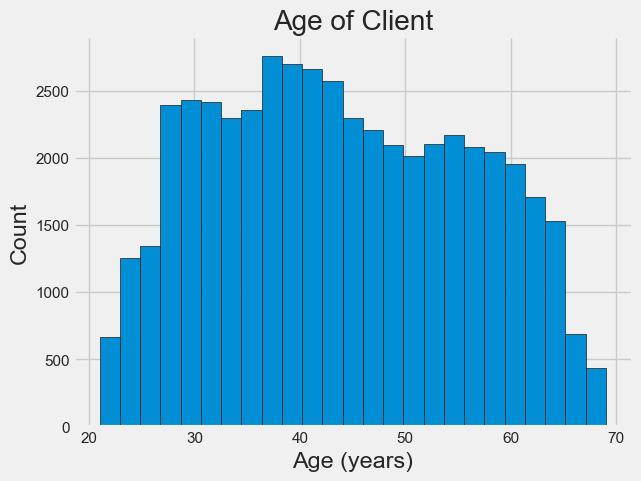

In [323]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(X_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

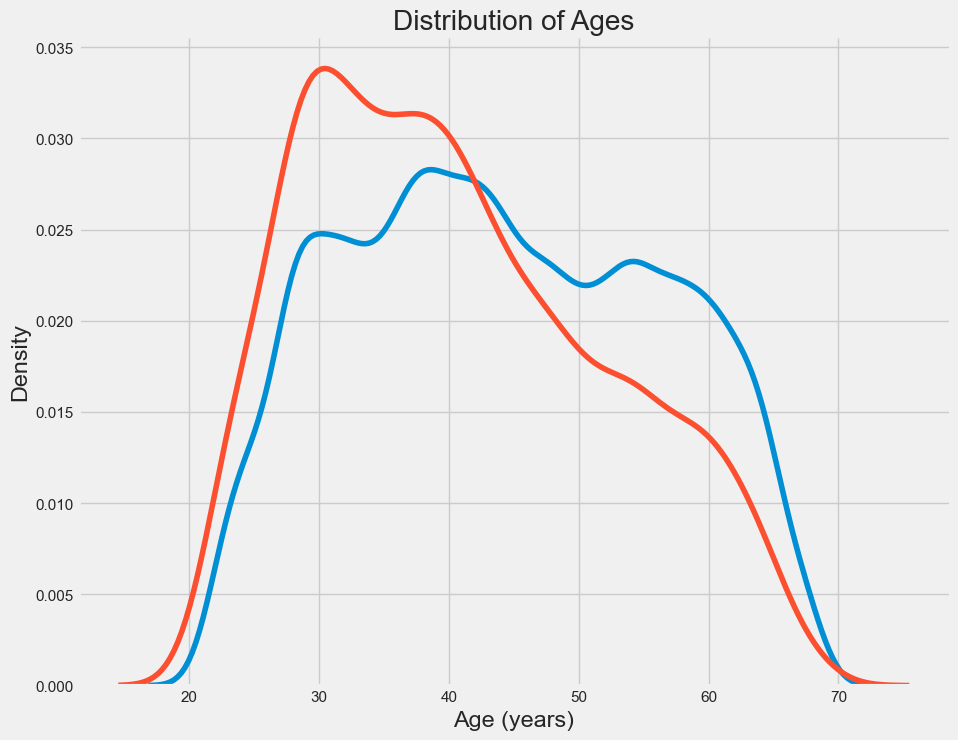

In [324]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(X_train.loc[X_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(X_train.loc[X_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

La courbe de la cible == 1 penche vers l'extrémité la plus jeune de la fourchette. Bien qu'il ne s'agisse pas d'une corrélation significative (coefficient de corrélation de -0,07), cette variable sera probablement utile dans un modèle d'apprentissage automatique car elle affecte la cible. Examinons cette relation sous un autre angle : le taux moyen de non-remboursement des prêts par tranche d'âge. 

Pour créer ce graphique, nous commençons par "découper" la catégorie d'âge en tranches de 5 ans chacune. Ensuite, pour chaque tranche, nous calculons la valeur moyenne de la cible, qui nous indique le ratio de prêts non remboursés dans chaque catégorie d'âge.

In [325]:
# Age information into a separate dataframe
age_data = X_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
282535,0,15257,41.800000,"(40.0, 45.0]"
180132,0,18441,50.523288,"(50.0, 55.0]"
11046,0,10290,28.191781,"(25.0, 30.0]"
77297,0,15242,41.758904,"(40.0, 45.0]"
140280,0,20365,55.794521,"(55.0, 60.0]"
283541,0,18692,51.210959,"(50.0, 55.0]"
190732,0,13501,36.989041,"(35.0, 40.0]"
247893,0,10122,27.731507,"(25.0, 30.0]"
136446,0,13424,36.778082,"(35.0, 40.0]"
178020,0,12569,34.435616,"(30.0, 35.0]"


In [326]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.125124,8531.404055,23.373710
"(25.0, 30.0]",0.107480,10159.957310,27.835499
"(30.0, 35.0]",0.103111,11852.094152,32.471491
"(35.0, 40.0]",0.090723,13709.113769,37.559216
"(40.0, 45.0]",0.076992,15496.180491,42.455289
"(45.0, 50.0]",0.072115,17323.684295,47.462149
"(50.0, 55.0]",0.060254,19191.236298,52.578730
"(55.0, 60.0]",0.054972,20989.803565,57.506311
"(60.0, 65.0]",0.050707,22770.831501,62.385840


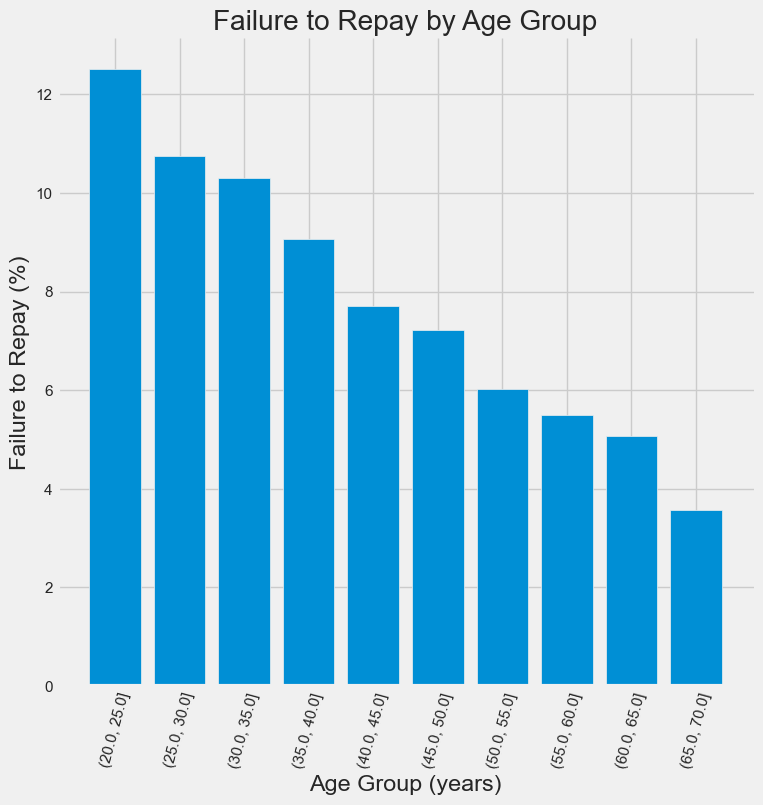

In [327]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

In [328]:
# Find the correlation of the positive days since birth and target
X_train['DAYS_BIRTH'] = X_train['DAYS_BIRTH']/365
X_test['DAYS_BIRTH'] = X_test['DAYS_BIRTH']/365
X_valid['DAYS_BIRTH'] = X_valid['DAYS_BIRTH']/365

### Variables Exterior Sources

Les 3 variables avec forte corrélation negative avec la cible = `EXT_SOURCE_1`, `EXT_SOURCE_2`, and `EXT_SOURCE_3`.
Selon la documentation, ces caractéristiques représentent un "score normalisé provenant d'une source de données externe". Il s'agit d'une d'évaluation cumulative du crédit réalisée à partir de données externes. 
Tout d'abord, nous pouvons montrer les corrélations des caractéristiques `EXT_SOURCE` avec la cible et entre elles.

In [329]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = X_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.149291,-0.164684,-0.180036,-0.081456
EXT_SOURCE_1,-0.149291,1.000000,0.222673,0.194221,0.605242
EXT_SOURCE_2,-0.164684,0.222673,1.000000,0.114914,0.099735
EXT_SOURCE_3,-0.180036,0.194221,0.114914,1.000000,0.205195
DAYS_BIRTH,-0.081456,0.605242,0.099735,0.205195,1.000000


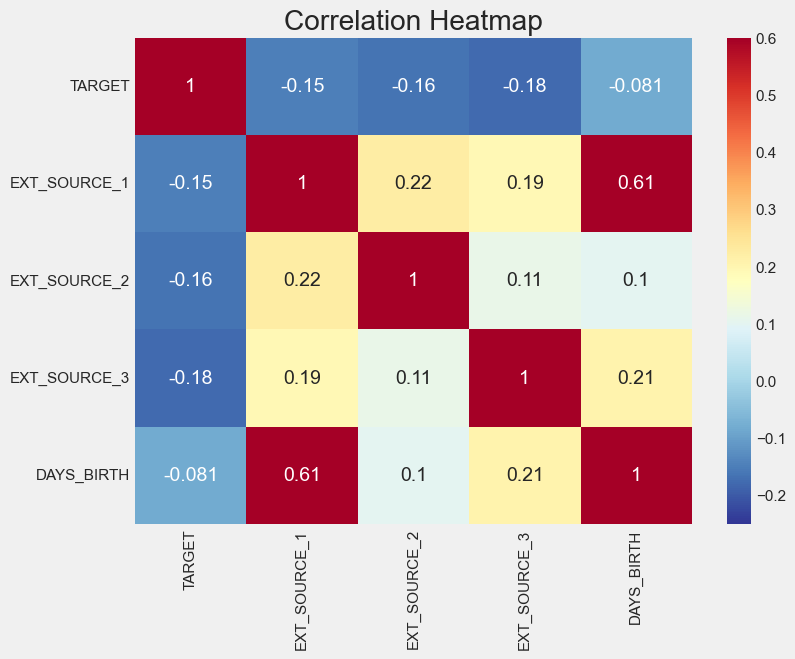

In [330]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

Les trois caractéristiques `EXT_SOURCE` ont des corrélations négatives avec la cible, ce qui indique que plus la valeur de `EXT_SOURCE` augmente, plus le client est susceptible de rembourser le prêt. Nous pouvons également voir que `DAYS_BIRTH` est positivement corrélé avec `EXT_SOURCE_1`, ce qui indique que l'un des facteurs de ce score est peut-être l'âge du client.

Ensuite, nous pouvons regarder la distribution de chacune de ces caractéristiques colorée par la valeur de la cible. Cela nous permettra de visualiser l'effet de cette variable sur la cible.

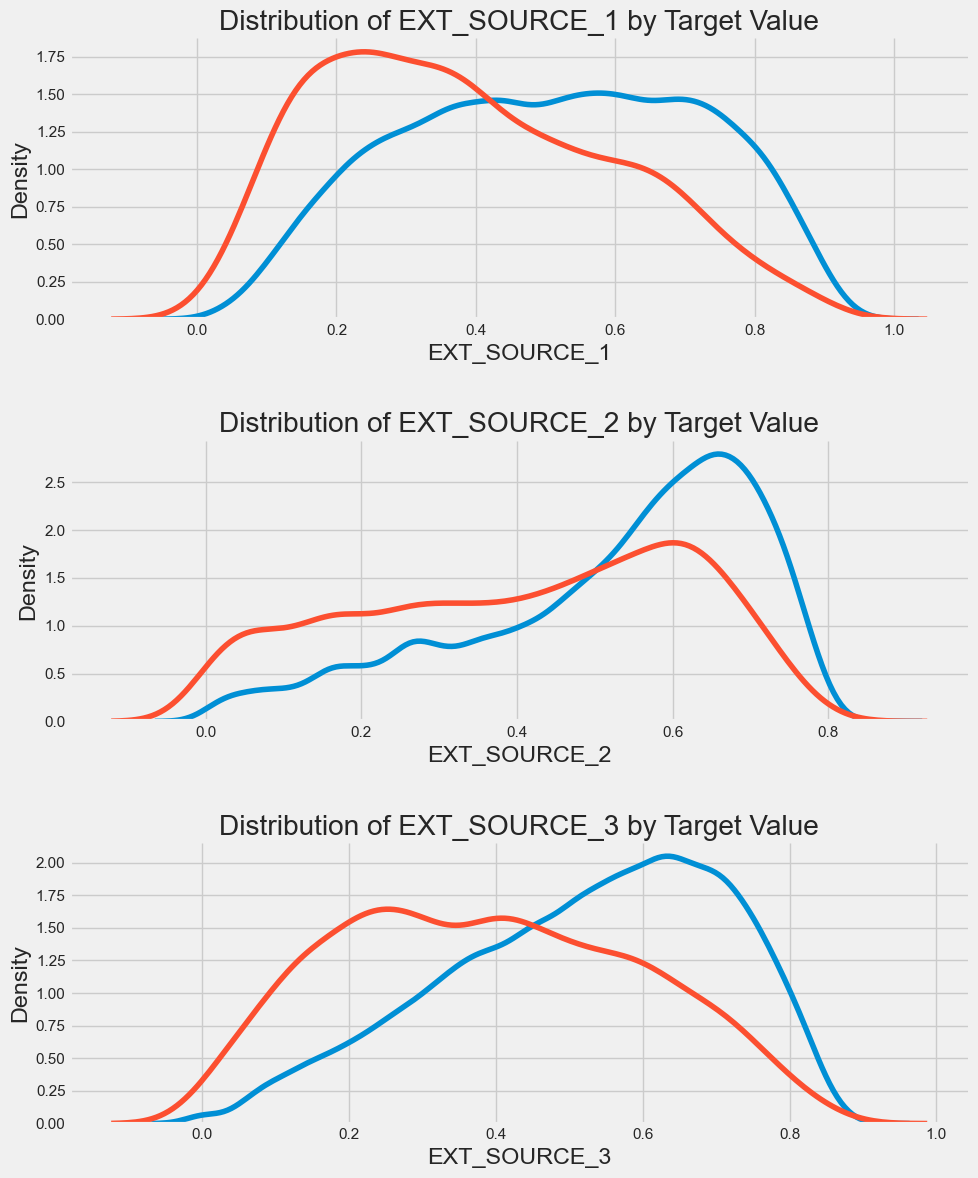

In [331]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(X_train.loc[X_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(X_train.loc[X_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)
    

`EXT_SOURCE_3` affiche la plus grande différence entre les valeurs de la cible. Nous pouvons clairement voir que cette caractéristique a une certaine relation avec la probabilité qu'un demandeur rembourse un prêt.

# Feature Engineering


## Features connaissance domaine

Ici, je vais utiliser cinq caractéristiques qui ont été inspirées par [ce script] (https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) d'Aguiar :

* `CREDIT_INCOME_PERCENT` : le pourcentage du montant du crédit par rapport au revenu du client.
* `ANNUITY_INCOME_PERCENT` : le pourcentage de l'annuité du prêt par rapport au revenu du client
* `CREDIT_TERM` : la durée du paiement en mois (puisque l'annuité est le montant mensuel dû)
* `DAYS_EMPLOYED_PERCENT` : le pourcentage des jours de travail par rapport à l'âge du client.


In [332]:
X_train['CREDIT_INCOME_PERCENT'] = X_train['AMT_CREDIT'] / X_train['AMT_INCOME_TOTAL']
X_train['ANNUITY_INCOME_PERCENT'] = X_train['AMT_ANNUITY'] / X_train['AMT_INCOME_TOTAL']
X_train['CREDIT_TERM'] = X_train['AMT_ANNUITY'] / X_train['AMT_CREDIT']
X_train['DAYS_EMPLOYED_PERCENT'] = X_train['DAYS_EMPLOYED'] / X_train['DAYS_BIRTH']

In [333]:
X_train['OCCUPATION_TYPE'].unique()

array(['Sales staff', 'Drivers', nan, 'Private service staff', 'Laborers',
       'Waiters/barmen staff', 'Managers', 'Core staff',
       'High skill tech staff', 'Cooking staff', 'Medicine staff',
       'Accountants', 'Cleaning staff', 'Security staff', 'Realty agents',
       'HR staff', 'Low-skill Laborers', 'Secretaries', 'IT staff'],
      dtype=object)

In [334]:
X_test['CREDIT_INCOME_PERCENT'] = X_test['AMT_CREDIT'] / X_test['AMT_INCOME_TOTAL']
X_test['ANNUITY_INCOME_PERCENT'] = X_test['AMT_ANNUITY'] / X_test['AMT_INCOME_TOTAL']
X_test['CREDIT_TERM'] = X_test['AMT_ANNUITY'] / X_test['AMT_CREDIT']
X_test['DAYS_EMPLOYED_PERCENT'] = X_test['DAYS_EMPLOYED'] / X_test['DAYS_BIRTH']

In [335]:
X_valid['CREDIT_INCOME_PERCENT'] = X_valid['AMT_CREDIT'] / X_valid['AMT_INCOME_TOTAL']
X_valid['ANNUITY_INCOME_PERCENT'] = X_valid['AMT_ANNUITY'] / X_valid['AMT_INCOME_TOTAL']
X_valid['CREDIT_TERM'] = X_valid['AMT_ANNUITY'] / X_valid['AMT_CREDIT']
X_valid['DAYS_EMPLOYED_PERCENT'] = X_valid['DAYS_EMPLOYED'] / X_valid['DAYS_BIRTH']

In [336]:
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(49201, 127)
(6150, 127)
(6150, 127)


#### Visualisation des nouvelles variables

Nous devrions explorer ces variables de __connaissance domaine__ visuellement dans un graphique. Pour toutes ces variables, nous ferons le même graphique KDE coloré par la valeur de la `TARGET`.

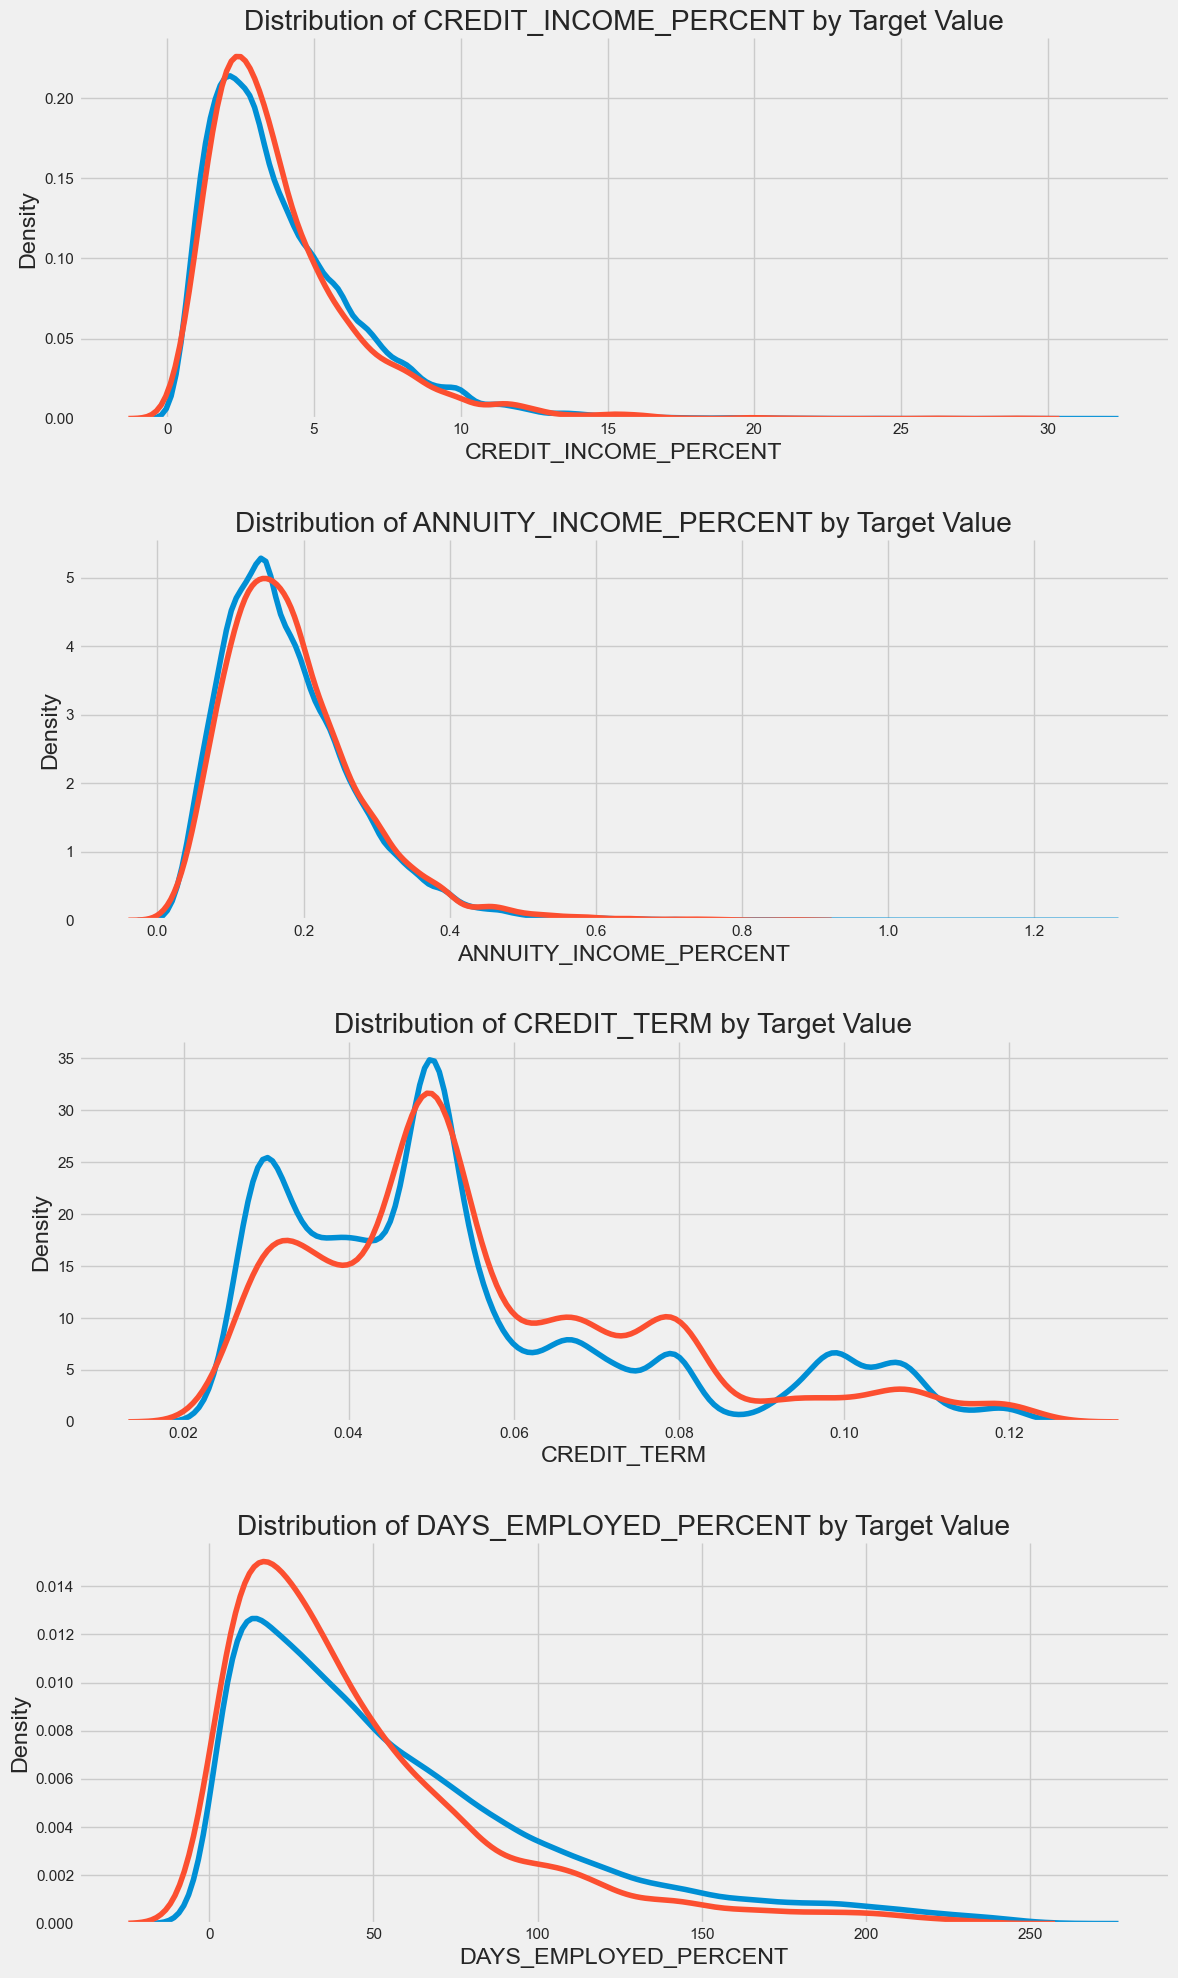

In [337]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(X_train.loc[X_train['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(X_train.loc[X_train['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

In [338]:
target_name = "TARGET"
y_train = X_train[target_name]

In [339]:
X_train['DAYS_EMPLOYED_ANOM'] = X_train.select_dtypes(include='bool').astype('uint8')
X_test['DAYS_EMPLOYED_ANOM'] = X_test.select_dtypes(include='bool').astype('uint8')
X_valid['DAYS_EMPLOYED_ANOM'] = X_valid.select_dtypes(include='bool').astype('uint8')
X_train.dtypes.value_counts()

float64    71
int64      39
object     16
uint8       1
Name: count, dtype: int64

## Features selection 

In [340]:
#Au moyen de SELECTKBEST et Features importance, nous avons sélectionné 10 variables. 
# Nous sommes contraints de choisir un petit nombre de variable pour la sutie du projet (compatibilité dashboard interactif)

In [341]:
skb_columns = ['TARGET', 'SK_ID_CURR', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CREDIT_TERM',
       'CREDIT_INCOME_PERCENT', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'ORGANIZATION_TYPE', 'OCCUPATION_TYPE',
       'CNT_CHILDREN']

In [342]:
X_train = X_train[skb_columns]
X_test = X_test[skb_columns]
X_valid = X_valid[skb_columns]

In [343]:
X_train

,TARGET,SK_ID_CURR,DAYS_BIRTH,DAYS_EMPLOYED,CREDIT_TERM,CREDIT_INCOME_PERCENT,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,ORGANIZATION_TYPE,OCCUPATION_TYPE,CNT_CHILDREN
282535,0,427269,41.800000,1580.0,0.035430,5.990000,NaN,0.468075,0.162442,Self-employed,Sales staff,0
180132,0,308750,50.523288,1540.0,0.101116,4.873125,0.465964,0.340995,0.771362,Self-employed,Drivers,0
11046,0,112866,28.191781,840.0,0.067234,1.544533,0.306959,0.606759,0.652897,Business Entity Type 3,NaN,2
77297,0,189625,41.758904,8181.0,0.029374,4.777422,NaN,0.642068,NaN,Business Entity Type 1,Private service staff,1
140280,0,262669,55.794521,2276.0,0.026632,2.865000,NaN,0.536679,0.819318,Business Entity Type 3,Laborers,1
...,...,...,...,...,...,...,...,...,...,...,...,...
271443,0,414684,47.304110,1588.0,0.027624,6.642171,NaN,0.601314,0.673830,Self-employed,Drivers,0
209565,0,342887,32.016438,3750.0,0.068052,4.653333,0.472866,0.401009,NaN,Medicine,Medicine staff,0
7973,0,109295,48.197260,3903.0,0.039596,2.558125,NaN,0.268869,0.425893,Other,Medicine staff,0
144448,0,267492,33.534247,1140.0,0.029359,6.410919,0.426441,0.764622,0.049263,Self-employed,Core staff,3


In [344]:
X_train.to_csv('X_tr.csv', index=False) 
X_test.to_csv('X_te.csv', index=False) 
#X_valid.to_csv('X_valid.csv',index=False)
y_train.to_csv('y_tr.csv', index=False) 
y_test.to_csv('y_te.csv', index=False)  
#y_valid.to_csv('y_valid.csv',index=False) 

In [345]:
X_train_evidently = X_train.copy()
X_test_evidently = X_test.copy()
X_valid_evidently = X_valid.copy()

y_train_evidently = y_train.copy()
y_test_evidently = y_test.copy()
y_valid_evidently = y_valid.copy()

In [346]:
X_train = X_train.drop(columns=['TARGET', 'SK_ID_CURR'])
X_test = X_test.drop(columns=['TARGET', 'SK_ID_CURR'])
X_valid = X_valid.drop(columns=['TARGET', 'SK_ID_CURR'])

In [347]:
X_train.to_csv('X_train.csv', index=False) 
X_test.to_csv('X_test.csv', index=False) 
#X_valid.to_csv('X_valid.csv',index=False)
y_train.to_csv('y_train.csv', index=False) 
y_test.to_csv('y_test.csv', index=False)  
#y_valid.to_csv('y_valid.csv',index=False) 

In [348]:
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(49201, 10)
(6150, 10)
(6150, 10)


# Création du pipeline

In [349]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
import xgboost 
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from sklearn import set_config

features_X_train = X_train.columns
features_X_test = X_test.columns
features_X_valid = X_valid.columns

#class_weight={0:1, 1:12}
# Define the encoding strategy for features
categorical_features = X_train.select_dtypes(include='object').columns
numerical_features = X_train.select_dtypes(exclude="object").columns
n_unique_categories = X_train[categorical_features].nunique().sort_values(ascending=False)
high_cardinality_features = n_unique_categories[n_unique_categories > 15].index
low_cardinality_features = n_unique_categories[n_unique_categories <= 15].index

set_config(transform_output="pandas")

# Define the preprocessing steps for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])

# Define the preprocessing steps for categorical features
high_categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('targ', TargetEncoder()),
    ('scaler', MinMaxScaler())])

# Define the preprocessing steps for categorical features
low_categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown="ignore"))])

# Use ColumnTransformer to apply the transformations to the correct columns in the dataframe
preprocessor = ColumnTransformer(
    transformers=[
        ("n", numeric_transformer, numerical_features),
        ("h", high_categorical_transformer, high_cardinality_features),
        ("l", low_categorical_transformer, low_cardinality_features)])

In [350]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier


# define pipeline
steps1 = [('preprocessor', preprocessor), ('over', SMOTE(random_state=1)), ('model', LogisticRegression(random_state=1))]
LogisticRegression = Pipeline(steps=steps1)

steps2 = [('preprocessor', preprocessor), ('over', SMOTE(random_state=1)), ('model', DummyClassifier(random_state=1))]
DummyClassifier = Pipeline(steps=steps2)

steps3 = [('preprocessor', preprocessor), ('over', SMOTE(random_state=1)), ('model', RandomForestClassifier(random_state=1))]
RandomForest = Pipeline(steps=steps3)

steps4 = [('preprocessor', preprocessor), ('over', SMOTE(random_state=1)), ('model', GradientBoostingClassifier(random_state=1))]
GradientBoosting = Pipeline(steps=steps4)

steps5 = [('preprocessor', preprocessor), ('over', SMOTE(random_state=1)), ('model', XGBClassifier(random_state=1))]
XGBClass = Pipeline(steps=steps5)

In [351]:
XGBClass

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('n',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['DAYS_BIRTH', 'DAYS_EMPLOYED', 'CREDIT_TERM', 'CREDIT_INCOME_PERCENT',
       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'CNT_CHILDREN'],
      dtype='object')),
                                                 ('h',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleIm...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=1, ...))])

# Premier entrainement de modèles

In [352]:
# Création d'une métrique adaptée Fbeta score pour le GridSearchCV https://scikit-learn.org/stable/modules/model_evaluation.html
from sklearn import metrics
from sklearn.metrics import fbeta_score, make_scorer

def bank_metric(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=10)

In [353]:
bank_score = make_scorer(bank_metric, greater_is_better=True)

In [354]:
dict_of_models = {"LogisticRegression": LogisticRegression, 
                  "DummyClassifier" : DummyClassifier, 
                  "RandomForest" : RandomForest,
                  "GradientBoosting" : GradientBoosting,
                  "XGBClass" : XGBClass}

In [355]:
def print_auto_logged_info(r):
    tags = {k: v for k, v in r.data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in MlflowClient().list_artifacts(r.info.run_id, "model")]
    print(f"run_id: {r.info.run_id}")
    print(f"artifacts: {artifacts}")
    print(f"params: {r.data.params}")
    print(f"metrics: {r.data.metrics}")
    print(f"tags: {tags}")

In [356]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score, roc_curve
from sklearn.model_selection import cross_val_score
from time import time
from mlflow import MlflowClient
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from mlflow import log_param, log_metrics, set_tag
from mlflow.sklearn import log_model
from mlflow.models import infer_signature
warnings.filterwarnings("ignore")

def evaluation(model):
        
        with mlflow.start_run() as run:
           
            start_fit = time()
            model.fit(X_train, y_train)
            end_fit = time()
            start_predict_train = time()
            y_pred_train = model.predict(X_train)
            y_proba_train = model.predict_proba(X_train)[:, 1] # keep probabilities for the positive outcome only
            end_predict_train = time()
            start_predict_test = time()
            y_pred_test = model.predict(X_test)
            y_proba_test = model.predict_proba(X_test)[:, 1]
            end_predict_test = time()
        
            bank_metric_train = bank_metric(y_train, y_pred_train)
            bank_metric_test = bank_metric(y_test, y_pred_test)
            roc_auc_score_train = roc_auc_score(y_train, y_proba_train)
            roc_auc_score_test = roc_auc_score(y_test, y_proba_test)
            fit_time = end_fit - start_fit
            predict_time_train = end_predict_train - start_predict_train
            predict_time_test = end_predict_test - start_predict_test
            roc_curve_train = roc_curve(y_train, y_pred_train)
            roc_curve_test = roc_curve(y_test, y_pred_test)
        
            print_auto_logged_info(mlflow.get_run(run_id=run.info.run_id))
            mlflow.end_run()
        
        df_result = pd.DataFrame({
        "data" : ["train", "test"],
        "bank_metric" : [bank_metric_train, bank_metric_test],
        "AUC" : [roc_auc_score(y_train, y_proba_train), roc_auc_score(y_test, y_proba_test)],
        "fit_time" : [fit_time, fit_time],
        "predict_time" : [predict_time_train, predict_time_test]})
        
        metric = ['bank_metric','AUC', 'fit_time', 'predict_time']
        custom_params = {"axes.spines.right": False, "axes.spines.top": False}
        sns.set_theme(style="ticks", rc=custom_params)
        fig = plt.figure(figsize=(20,60))

        for i, c in enumerate(metric,1):
            ax = fig.add_subplot(2,4,i)
            sns.barplot(data=df_result, x="data", y=df_result[c], palette = "Set3")
            plt.xticks(fontsize= 20)
            plt.yticks(fontsize= 14)
            plt.xlabel("", fontsize= 20)
            plt.ylabel(c, fontsize= 20)
            #plt.ylim(0, 1) 

        plt.tight_layout(w_pad=2, h_pad=1)
        plt.gcf().set_size_inches(16,7)
        plt.show()        
    
        return df_result

LogisticRegression


2023/12/21 15:35:41 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


2023/12/21 15:35:44 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 15:35:44 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 15:35:44 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 15:35:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 4e5c052d88824be898635a5761b00877. Failed operations: [MlflowException("Changing pa

run_id: 4e5c052d88824be898635a5761b00877
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'C': '1.0', 'class_weight': 'None', 'dual': 'False', 'fit_intercept': 'True', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'intercept_scaling': '1', 'l1_ratio': 'None', 'leaf_size': '30', 'max_iter': '100', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'multi_class': 'auto', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'penalty': 'l2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False', 'scaler__copy': 'True', 'scaler__feature_range': '(0, 1)', 'solver': 'lbfgs', 'steps': "[('imputer', SimpleImputer(strategy='median')), ('scaler', MinMaxScaler

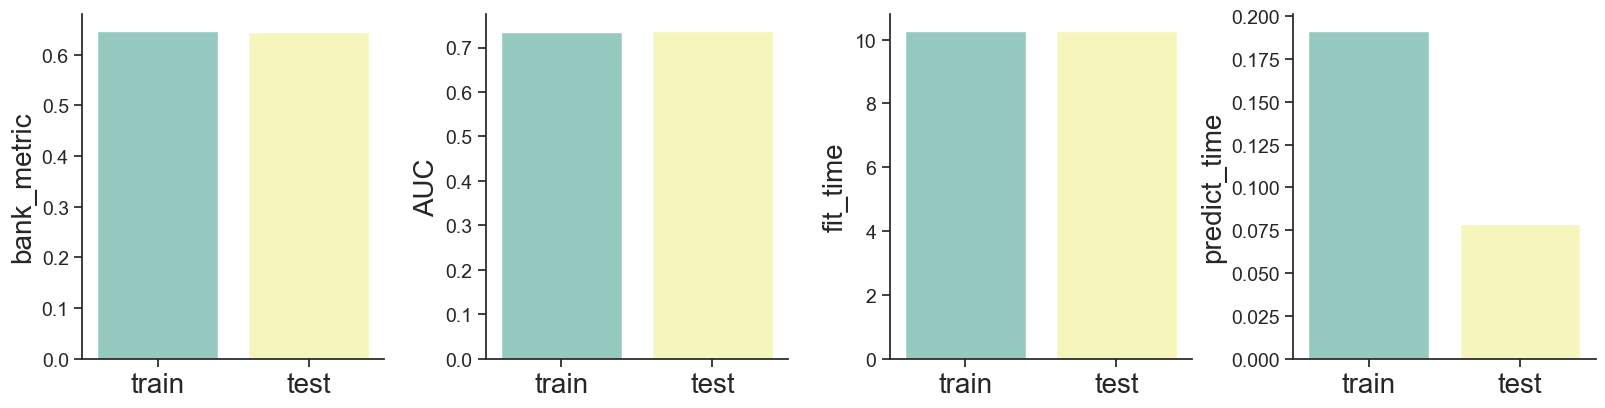

DummyClassifier


2023/12/21 15:35:52 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 15:35:54 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 15:35:54 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 15:35:54 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 15:35:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or 

run_id: 7c3fb42519fd48a794bcd96124895a81
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'constant': 'None', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'leaf_size': '30', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False', 'scaler__copy': 'True', 'scaler__feature_range': '(0, 1)', 'steps': "[('imputer', SimpleImputer(strategy='median')), ('scaler', MinMaxScaler())]", 'strategy': 'prior', 'verbose': 'False'}
metrics: {'fbeta_score-2_Xt-3': 0.0, 'fbeta_score_Xt': 0.0, 'training_accuracy_score': 0.5, 'training_f1_score': 0.3333333333333333, '

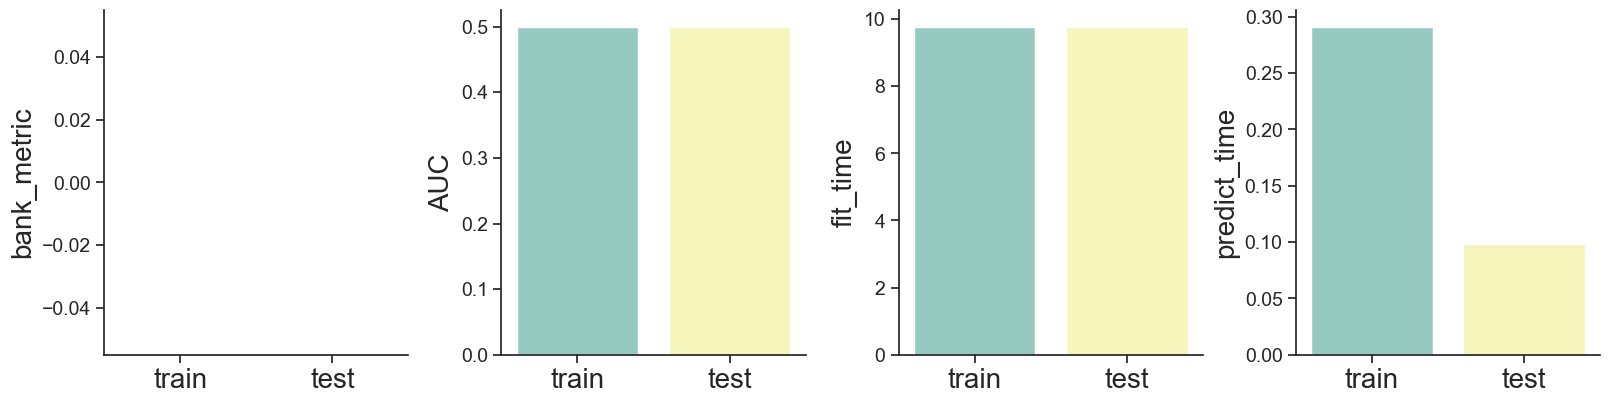

RandomForest


2023/12/21 15:36:03 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 15:36:05 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 15:36:05 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 15:36:05 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 15:36:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or 

run_id: d8fb750ca9eb46849088696a48095c4a
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'bootstrap': 'True', 'ccp_alpha': '0.0', 'class_weight': 'None', 'criterion': 'gini', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'leaf_size': '30', 'max_depth': 'None', 'max_features': 'sqrt', 'max_leaf_nodes': 'None', 'max_samples': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '100', 'n_jobs': 'None', 'n_neighbors': '6', 'oob_score': 'False', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False',

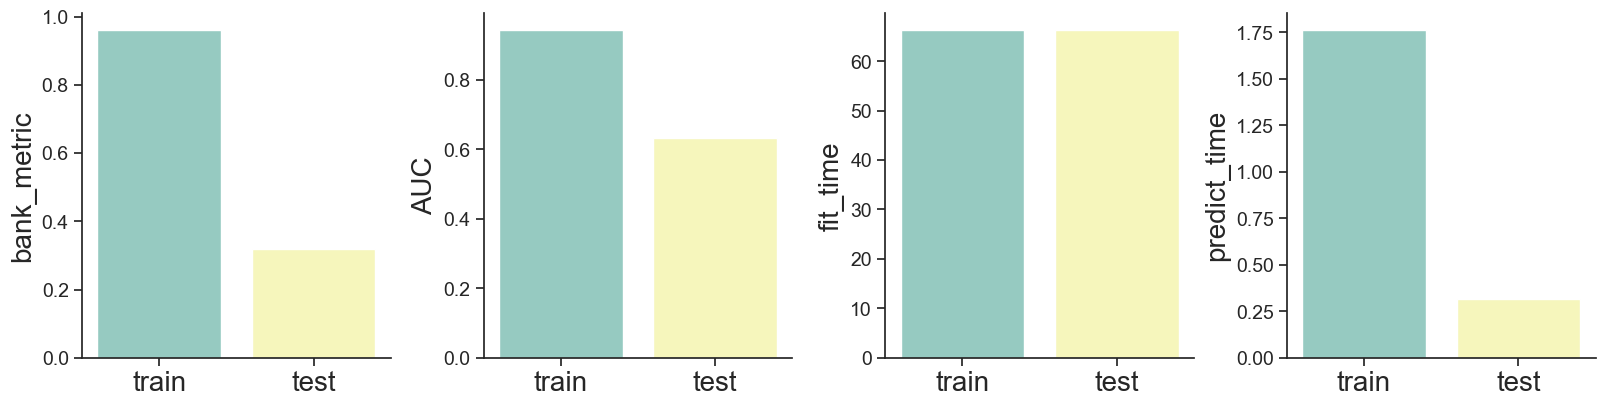

GradientBoosting


2023/12/21 15:37:12 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 15:37:14 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 15:37:14 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 15:37:14 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 15:37:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or 

run_id: 196510e0954443898cce33cf105bdf8b
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '100', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'Fals

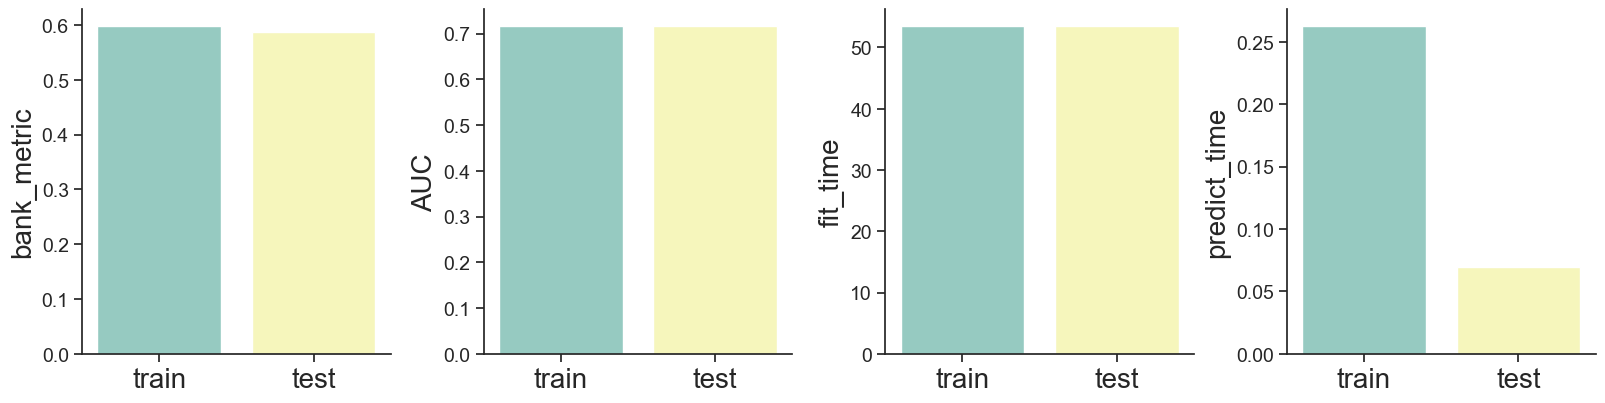

XGBClass


2023/12/21 15:38:06 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 15:38:08 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 15:38:08 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 15:38:08 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 15:38:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or 

run_id: 7237cd7a60a5490d88072f5d01fb5097
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/model.xgb', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'base_score': 'None', 'booster': 'None', 'colsample_bylevel': 'None', 'colsample_bynode': 'None', 'colsample_bytree': 'None', 'custom_metric': 'None', 'device': 'None', 'early_stopping_rounds': 'None', 'eval_metric': 'None', 'gamma': 'None', 'grow_policy': 'None', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'interaction_constraints': 'None', 'leaf_size': '30', 'learning_rate': 'None', 'maximize': 'None', 'max_bin': 'None', 'max_cat_threshold': 'None', 'max_cat_to_onehot': 'None', 'max_delta_step': 'None', 'max_depth': 'None', 'max_leaves': 'None', 'memory': 'None', 'metric': 'minkowsk

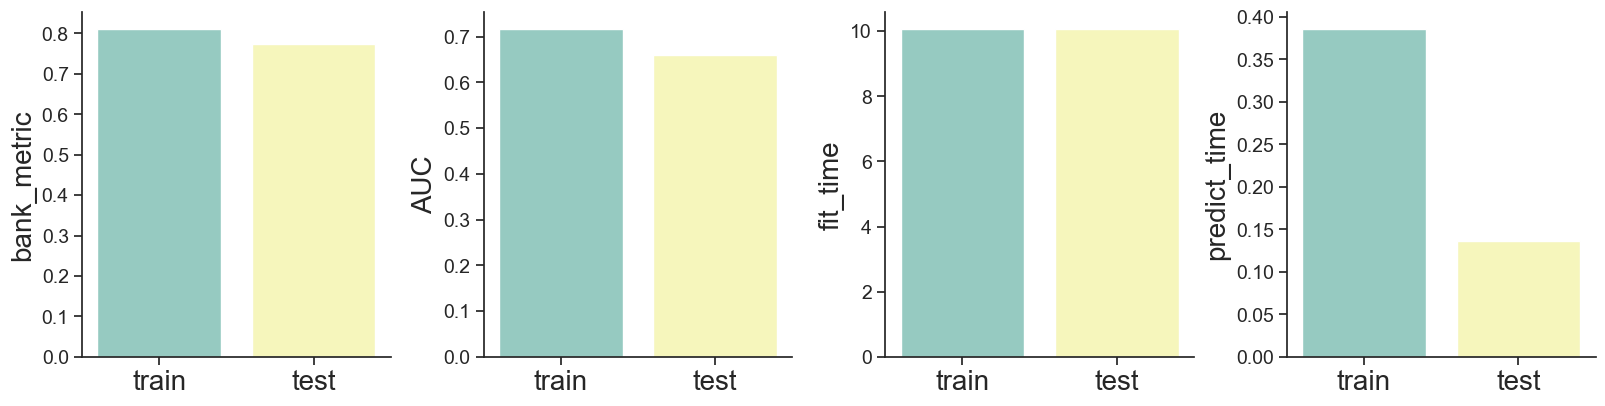

In [357]:
for name, model in dict_of_models.items():
    print(name)
    evaluation(model)

# Cross validation et hparams tuning avec GridsearchCV

Déterminer les meilleurs hparams des modèles. Le scoring GridCV est notre métrique métier. 
Nous évaluons ensuite les probabilités de solvabilité obtenues grâce à des métrics spécifiques (AUC, accuracy_precision_score). 

The F-beta score is the weighted harmonic mean of precision and recall, reaching its optimal value at 1 and its worst value at 0.

The beta parameter represents the ratio of recall importance to precision importance. beta > 1 gives more weight to recall, while beta < 1 favors precision. For example, beta = 2 makes recall twice as important as precision, while beta = 0.5 does the opposite. Asymptotically, beta -> +inf considers only recall, and beta -> 0 only precision.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html

In [358]:
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 150, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Create the grid
param_grid_rf = {'model__n_estimators': n_estimators,
               'model__max_features': max_features}

In [359]:
from sklearn.model_selection import GridSearchCV
from pprint import pprint

learning_rate = [0.1, 0.01]
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 150, num = 3)]

param_grid_gbc = {'model__learning_rate': learning_rate,
                  'model__n_estimators': n_estimators}

In [360]:
from sklearn.model_selection import GridSearchCV
from pprint import pprint

learning_rate = [0.1, 0.01]
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 150, num = 3)]

param_grid_xgb = {'model__learning_rate': learning_rate,
                  'model__n_estimators' : n_estimators}


In [361]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

def cv_gridsearch_control(model, param_grid):
    
    with mlflow.start_run() as run:
        # evaluate pipeline
        cv = StratifiedKFold(n_splits=5)
        grid = GridSearchCV(model, param_grid, cv=cv, scoring=roc_auc_score)
        grid.fit(X_train, y_train)
        
    print_auto_logged_info(mlflow.get_run(run_id=run.info.run_id))
    mlflow.end_run()
    
    # Get the results
    best_score = grid.best_score_
    print("best_score=", best_score)
    best_params = grid.best_params_
    print("best_params=", best_params)

In [362]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

def cv_gridsearch_bank(model, param_grid):
    
    with mlflow.start_run() as run:
        # evaluate pipeline
        cv = StratifiedKFold(n_splits=5)
        grid = GridSearchCV(model, param_grid, cv=cv, scoring=bank_score)
        grid.fit(X_train, y_train)
    
    print_auto_logged_info(mlflow.get_run(run_id=run.info.run_id))
    mlflow.end_run()
    
    # Get the results
    best_score = grid.best_score_
    print("best_score=", best_score)
    best_params = grid.best_params_
    print("best_params=", best_params)

In [363]:
# cv_gridsearch_bank(RandomForest, param_grid_rf)
# #{'model__max_features': 'sqrt', 'model__n_estimators': 100}

In [364]:
# cv_gridsearch_bank(GradientBoosting, param_grid_gbc)
# # {'model__learning_rate': 0.1, 'model__n_estimators': 150}

In [365]:
# cv_gridsearch_bank(XGBClass, param_grid_xgb)
# # {'model__learning_rate': 0.1, 'model__n_estimators': 150}

# Retrainements avec hparams optimaux

In [366]:
import xgboost 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

steps6 = [('preprocessor', preprocessor), ('over', SMOTE(random_state=1)), 
          ('model', RandomForestClassifier(max_features="sqrt", n_estimators=100, random_state=1))]
RandomForest_tuned = Pipeline(steps=steps6)

steps7 = [('preprocessor', preprocessor), ('over', SMOTE(random_state=1)), 
          ('model',  GradientBoostingClassifier(learning_rate= 0.1, n_estimators= 150, random_state=1))]
GradientBoosting_tuned = Pipeline(steps=steps7)

steps8 = [('preprocessor', preprocessor), ('over', SMOTE(random_state=1)), 
          ('model', XGBClassifier(learning_rate= 0.1, n_estimators= 150, random_state=1))]
XGBClass_tuned = Pipeline(steps=steps8)

In [367]:
dict_of_tuned_models = {"RandomForest_tuned" : RandomForest_tuned,
                        "GradientBoosting_tuned" : GradientBoosting_tuned,
                        "XGBClass_tuned" : XGBClass_tuned}

# Evaluation des prédictions avec un threshold standard

Une fois les hparams optimisé, on évalue les prédictions avec un seuil standard (e.g., 0.5)

In [368]:
def transform_treshold(df, tresh):
    
    new_df = (df >= tresh).astype("int")
    
    return new_df

In [369]:
from sklearn.metrics import fbeta_score, accuracy_score, precision_score, recall_score, average_precision_score

def tuned_seuil_default(model):
    
    with mlflow.start_run() as run:
        model.fit(X_train, y_train)
        start_train = time()
        y_proba_train = model.predict_proba(X_train)[:, 1]
        end_train = time()
        y_proba_test = model.predict_proba(X_test)[:, 1]
        end_test = time()
        
    print_auto_logged_info(mlflow.get_run(run_id=run.info.run_id))
    mlflow.end_run()
    
    #Seuil de base 0.5 (à optimiser par la suite)
    df_predictions_train = pd.DataFrame()
    df_predictions_train["y_train"] = y_train 
    df_predictions_train['y_proba_train'] = y_proba_train
    y_pred_train = transform_treshold(df_predictions_train["y_proba_train"], 0.5)
    df_predictions_train['y_pred_train'] = y_pred_train
   
    # Calculate error metrics
    time_pred_train = end_train - start_train
    auc_train = roc_auc_score(y_train, y_proba_train)
    Average_precision_score_train = average_precision_score(y_train, y_proba_train)
    accuracy_train = accuracy_score(df_predictions_train["y_train"], df_predictions_train["y_pred_train"])
    precision_train = precision_score(df_predictions_train["y_train"], df_predictions_train["y_pred_train"])
    recall_train = recall_score(df_predictions_train["y_train"], df_predictions_train["y_pred_train"])
    bank_train = bank_metric(df_predictions_train["y_train"], df_predictions_train["y_pred_train"])
    
     #Seuil de base 0.5 (à optimiser par la suite)
    df_predictions_test = pd.DataFrame()
    df_predictions_test["y_test"] = y_test 
    df_predictions_test['y_proba_test'] = y_proba_test
    y_pred_test = transform_treshold(df_predictions_test["y_proba_test"], 0.5)
    df_predictions_test['y_pred_test'] = y_pred_test
   
    # Calculate error metrics
    time_pred_test = end_test - end_train
    auc_test = roc_auc_score(y_test, y_proba_test)
    accuracy_test = accuracy_score(df_predictions_test["y_test"], df_predictions_test["y_pred_test"])
    precision_test = precision_score(df_predictions_test["y_test"], df_predictions_test["y_pred_test"])
    recall_test = recall_score(df_predictions_test["y_test"], df_predictions_test["y_pred_test"])
    bank_test = bank_metric(df_predictions_test["y_test"], df_predictions_test["y_pred_test"])
    
    print ("time_pred = ", time_pred_train, time_pred_test)
    print ("auc = ", auc_train, auc_test)
    print ("accuracy = ", accuracy_train, accuracy_test)
    print("precision = ", precision_train, precision_test)
    print("recall =", recall_train, recall_test)
    print("bank_metric =", bank_train, bank_test)
    print("") 
    
    df_result = pd.DataFrame({
    "data" : ["train", "test"],
    "bank_metric" : [bank_train, bank_test],
    "auc" : [auc_train, auc_test],
    "accuracy" : [accuracy_train, accuracy_test],
    "precision" : [precision_train, precision_test],
    "recall" : [recall_train, recall_test],
    "time_pred" : [time_pred_train, time_pred_test]
    })
    
    metrics = ['bank_metric','auc', 'accuracy', 'precision', 'recall','time_pred']

    custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    sns.set_theme(style="ticks", rc=custom_params)
    fig = plt.figure(figsize=(20,60))

    for i, c in enumerate(metrics,1):
        ax = fig.add_subplot(2,7,i)
        sns.barplot(data=df_result, x="data", y=df_result[c], palette = "Set3")
        plt.xticks(fontsize= 16)
        plt.yticks(fontsize= 14)
        plt.xlabel("", fontsize= 16)
        plt.ylabel(c, fontsize= 16)
        #plt.ylim(0, 1) 

    plt.tight_layout(w_pad=2, h_pad=1)
    plt.gcf().set_size_inches(16,7)
    plt.show()
    
    return df_result, df_predictions_train, df_predictions_test

2023/12/21 15:38:17 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


RandomForest_tuned


2023/12/21 15:38:19 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 15:38:20 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 15:38:20 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 15:38:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID bc0344f9f2db4d309a846372189d8b90. Failed operations: [MlflowException("Changing pa

run_id: bc0344f9f2db4d309a846372189d8b90
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'bootstrap': 'True', 'ccp_alpha': '0.0', 'class_weight': 'None', 'criterion': 'gini', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'leaf_size': '30', 'max_depth': 'None', 'max_features': 'sqrt', 'max_leaf_nodes': 'None', 'max_samples': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '100', 'n_jobs': 'None', 'n_neighbors': '6', 'oob_score': 'False', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'False',

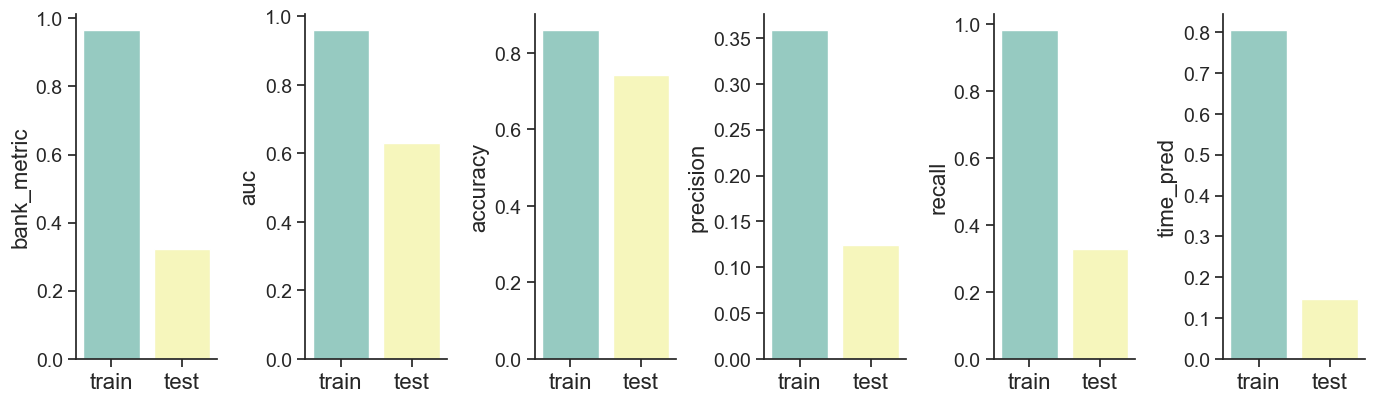

GradientBoosting_tuned


2023/12/21 15:39:24 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 15:39:27 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 15:39:27 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 15:39:27 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 15:39:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or 

run_id: 34c95bb3af6a41ab8f3e727101fdb587
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'ccp_alpha': '0.0', 'criterion': 'friedman_mse', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'init': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'loss': 'log_loss', 'max_depth': '3', 'max_features': 'None', 'max_leaf_nodes': 'None', 'memory': 'None', 'metric': 'minkowski', 'metric_params': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '150', 'n_iter_no_change': 'None', 'n_jobs': 'None', 'n_neighbors': '6', 'p': '2', 'radius': '1.0', 'random_state': '1', 'scaler': 'MinMaxScaler()', 'scaler__clip': 'Fals

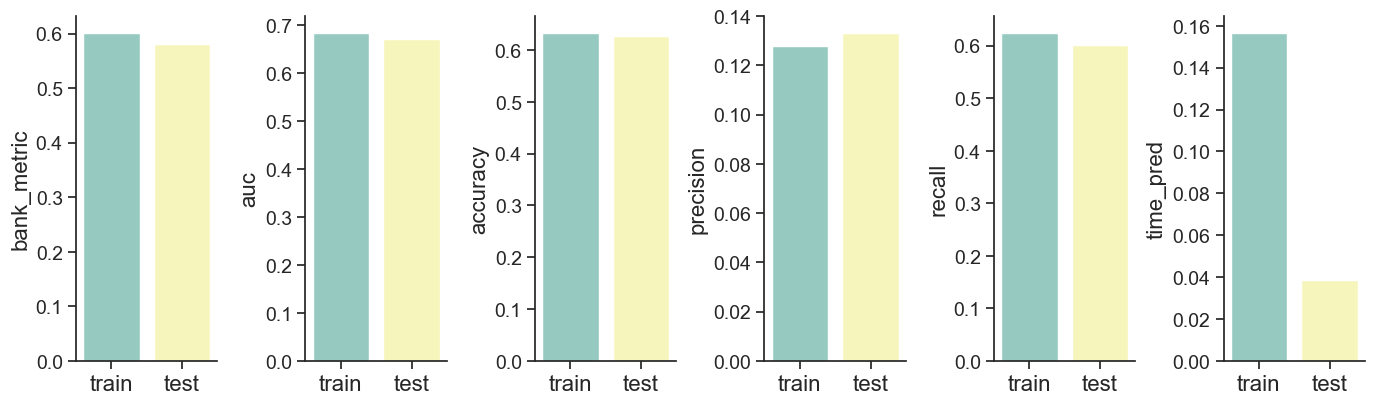

2023/12/21 15:40:38 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


XGBClass_tuned


2023/12/21 15:40:40 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 15:40:40 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 15:40:40 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 15:40:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 49ff453df4ca47aa85096a11db53204e. Failed operations: [MlflowException("Changing pa

run_id: 49ff453df4ca47aa85096a11db53204e
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/model.xgb', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'base_score': 'None', 'booster': 'None', 'colsample_bylevel': 'None', 'colsample_bynode': 'None', 'colsample_bytree': 'None', 'custom_metric': 'None', 'device': 'None', 'early_stopping_rounds': 'None', 'eval_metric': 'None', 'gamma': 'None', 'grow_policy': 'None', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'interaction_constraints': 'None', 'leaf_size': '30', 'learning_rate': '0.1', 'maximize': 'None', 'max_bin': 'None', 'max_cat_threshold': 'None', 'max_cat_to_onehot': 'None', 'max_delta_step': 'None', 'max_depth': 'None', 'max_leaves': 'None', 'memory': 'None', 'metric': 'minkowski

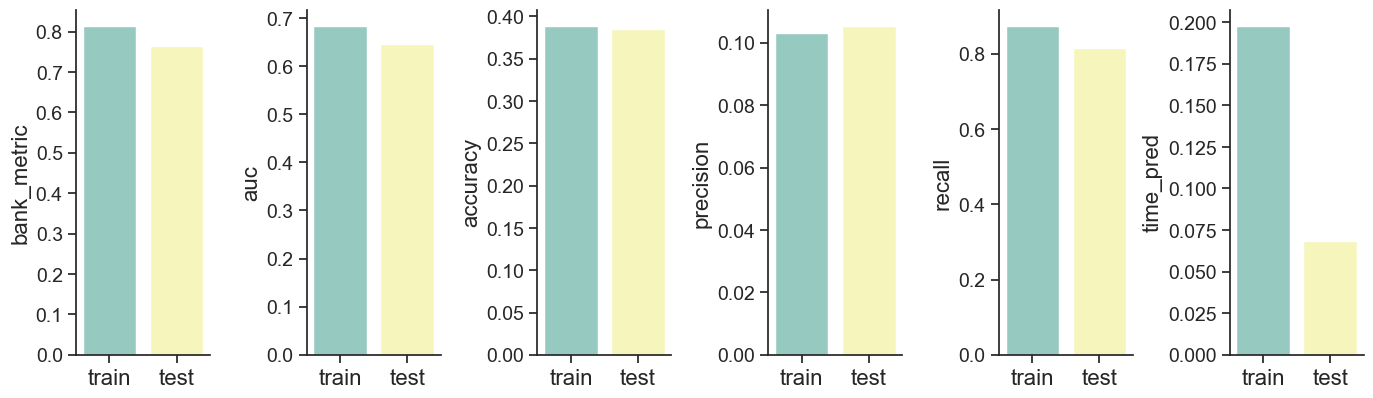

In [370]:
for name, model in dict_of_tuned_models.items():
    print(name)
    tuned_seuil_default(model)

When to Use ROC vs. Precision-Recall Curves?
Generally, the use of ROC curves and precision-recall curves are as follows:

ROC curves should be used when there are roughly equal numbers of observations for each class.
Precision-Recall curves should be used when there is a moderate to large class imbalance.

In [371]:
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

## Fine tuning des hyperparamètres

In [372]:
from sklearn.model_selection import GridSearchCV
from pprint import pprint

learning_rate = [0.1, 0.08, 0.06, 0.04, 0.02, 0.01]
n_estimators = [int(x) for x in np.linspace(start = 170, stop = 200, num = 10)]

param_grid_xgb = {'model__learning_rate': learning_rate,
                  'model__n_estimators' : n_estimators}


In [373]:
cv_gridsearch_bank(XGBClass_tuned, param_grid_xgb)
# # {'model__learning_rate': 0.1, 'model__n_estimators': 173}

2023/12/21 15:40:48 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 15:43:26 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 15:43:31 INFO mlflow.sklearn.utils: Logging the 5 best runs, 55 runs will be omitted.


run_id: e32f6b79edf84fcaa76414342a82a284
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
params: {'best_model__learning_rate': '0.1', 'best_model__n_estimators': '173', 'cv': 'StratifiedKFold(n_splits=5, random_state=None, shuffle=False)', 'error_score': 'nan', 'estimator': "Pipeline(steps=[('preprocessor',\n                 ColumnTransformer(transformers=[('n',\n                                                  Pipeline(steps=[('imputer',\n                                                                   SimpleImputer(strategy='median')),\n                                                                  ('scaler',\n                                                                   MinMaxScaler())]),\n                                                  Index(['DAYS_BIRTH', 'DAYS_EMPLOYED', 'CREDIT_TERM', 'CREDIT_INCOME_PERCENT',\n       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'CNT_CHILDREN'],\n      dtype='o

In [377]:
steps9 = [('preprocessor', preprocessor), ('over', SMOTE(random_state=1)), ('model', XGBClassifier(learning_rate= 0.1, n_estimators= 173, random_state=1))]
XGBClass_fine_tuned = Pipeline(steps=steps5)

2023/12/21 16:43:58 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 16:44:01 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 16:44:01 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 16:44:01 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 16:44:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or 

run_id: 9c2a60a44f5d4e5ea6db1686acf8d2b8
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/model.xgb', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'base_score': 'None', 'booster': 'None', 'colsample_bylevel': 'None', 'colsample_bynode': 'None', 'colsample_bytree': 'None', 'custom_metric': 'None', 'device': 'None', 'early_stopping_rounds': 'None', 'eval_metric': 'None', 'gamma': 'None', 'grow_policy': 'None', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'interaction_constraints': 'None', 'leaf_size': '30', 'learning_rate': 'None', 'maximize': 'None', 'max_bin': 'None', 'max_cat_threshold': 'None', 'max_cat_to_onehot': 'None', 'max_delta_step': 'None', 'max_depth': 'None', 'max_leaves': 'None', 'memory': 'None', 'metric': 'minkowsk

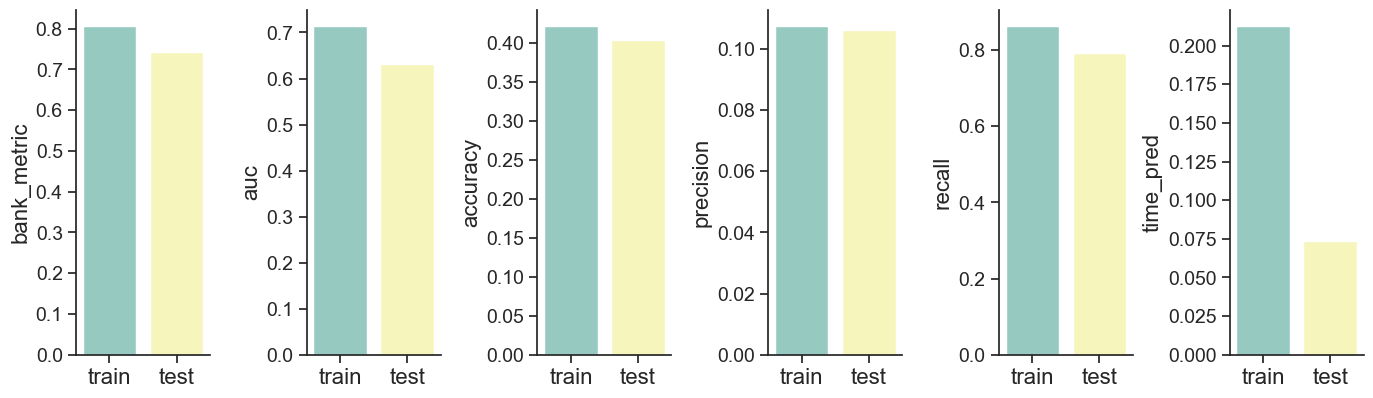

(    data  bank_metric       auc  accuracy  precision    recall  time_pred
 0  train     0.805790  0.713511  0.421617   0.107335  0.861874   0.212490
 1   test     0.743738  0.632007  0.404553   0.105992  0.791353   0.073675,
         y_train  y_proba_train  y_pred_train
 282535        0       0.837056             1
 180132        0       0.507024             1
 11046         0       0.684639             1
 77297         0       0.236747             0
 140280        0       0.907033             1
 ...         ...            ...           ...
 271443        0       0.557162             1
 209565        0       0.382869             0
 7973          0       0.785168             1
 144448        0       0.085279             0
 156409        0       0.267215             0
 
 [49201 rows x 3 columns],
         y_test  y_proba_test  y_pred_test
 39370        0      0.771115            1
 155080       1      0.255904            0
 18001        0      0.571692            1
 200004       1      

In [430]:
tuned_seuil_default(XGBClass_fine_tuned)

## Recherche du threshold de prediction optimal (0->1)

Déterminer le meilleur seuil technique pour les meilleurs hparams de l'étape précédente

In [378]:
from sklearn.metrics import f1_score, roc_auc_score

def seuil_solvabilité(model, X, y):
    
    fonction_cout = []
    #fonction_f1score = []
    fonction_auc = []
    seuils = np.linspace(0.0, 1, 10)

    for seuil in seuils:

        with mlflow.start_run() as run:
            # Score du modèle : n = 0 ou 1
            model.fit(X_train, y_train)
            y_score = pd.DataFrame(model.predict_proba(X)[:, 1])

            # Score > seuil de solvabilité : retourne 1 sinon 0
            y_pred = (y_score >= seuil).astype("int")
            #y_pred = np.array(y_pred)
        
        print_auto_logged_info(mlflow.get_run(run_id=run.info.run_id))
        mlflow.end_run()

        # Calcul de l'indice bancaire
        fonction_cout.append(bank_metric(y, y_pred))
        #fonction_f1score.append(f1_score(y_test, y_pred))
        fonction_auc.append(roc_auc_score(y_test, y_score))
    
    plt.figure(figsize=(5, 2.7), layout='constrained')
    plt.plot(seuils, fonction_cout, label='bank_metric')  # Plot some data on the (implicit) axes.
    #plt.plot(seuils, fonction_f1score, label='f1_score')
    plt.plot(seuils, fonction_auc, label='roc_auc_score')
    plt.xlabel('Seuil de probabilité')
    plt.ylabel('Métriques')
    plt.legend()
    

2023/12/21 15:44:15 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


2023/12/21 15:44:18 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 15:44:18 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 15:44:18 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 15:44:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 1f60e553daa14d2f824344e47b475424. Failed operations: [MlflowException("Changing pa

run_id: 1f60e553daa14d2f824344e47b475424
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/model.xgb', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'base_score': 'None', 'booster': 'None', 'colsample_bylevel': 'None', 'colsample_bynode': 'None', 'colsample_bytree': 'None', 'custom_metric': 'None', 'device': 'None', 'early_stopping_rounds': 'None', 'eval_metric': 'None', 'gamma': 'None', 'grow_policy': 'None', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'interaction_constraints': 'None', 'leaf_size': '30', 'learning_rate': 'None', 'maximize': 'None', 'max_bin': 'None', 'max_cat_threshold': 'None', 'max_cat_to_onehot': 'None', 'max_delta_step': 'None', 'max_depth': 'None', 'max_leaves': 'None', 'memory': 'None', 'metric': 'minkowsk

2023/12/21 15:44:26 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 15:44:28 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 15:44:28 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 15:44:28 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 15:44:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or 

run_id: 1867620f9ef641d097efe8f77158bc4a
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/model.xgb', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'base_score': 'None', 'booster': 'None', 'colsample_bylevel': 'None', 'colsample_bynode': 'None', 'colsample_bytree': 'None', 'custom_metric': 'None', 'device': 'None', 'early_stopping_rounds': 'None', 'eval_metric': 'None', 'gamma': 'None', 'grow_policy': 'None', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'interaction_constraints': 'None', 'leaf_size': '30', 'learning_rate': 'None', 'maximize': 'None', 'max_bin': 'None', 'max_cat_threshold': 'None', 'max_cat_to_onehot': 'None', 'max_delta_step': 'None', 'max_depth': 'None', 'max_leaves': 'None', 'memory': 'None', 'metric': 'minkowsk

2023/12/21 15:44:35 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 15:44:37 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 15:44:38 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 15:44:38 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 15:44:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or 

run_id: 8e6d9e7f22b84b5f8121c2df9026b4b3
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/model.xgb', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'base_score': 'None', 'booster': 'None', 'colsample_bylevel': 'None', 'colsample_bynode': 'None', 'colsample_bytree': 'None', 'custom_metric': 'None', 'device': 'None', 'early_stopping_rounds': 'None', 'eval_metric': 'None', 'gamma': 'None', 'grow_policy': 'None', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'interaction_constraints': 'None', 'leaf_size': '30', 'learning_rate': 'None', 'maximize': 'None', 'max_bin': 'None', 'max_cat_threshold': 'None', 'max_cat_to_onehot': 'None', 'max_delta_step': 'None', 'max_depth': 'None', 'max_leaves': 'None', 'memory': 'None', 'metric': 'minkowsk

2023/12/21 15:44:45 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 15:44:47 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 15:44:47 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 15:44:47 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 15:44:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or 

run_id: 3c437f10008f4b768a9a6dbd04016780
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/model.xgb', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'base_score': 'None', 'booster': 'None', 'colsample_bylevel': 'None', 'colsample_bynode': 'None', 'colsample_bytree': 'None', 'custom_metric': 'None', 'device': 'None', 'early_stopping_rounds': 'None', 'eval_metric': 'None', 'gamma': 'None', 'grow_policy': 'None', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'interaction_constraints': 'None', 'leaf_size': '30', 'learning_rate': 'None', 'maximize': 'None', 'max_bin': 'None', 'max_cat_threshold': 'None', 'max_cat_to_onehot': 'None', 'max_delta_step': 'None', 'max_depth': 'None', 'max_leaves': 'None', 'memory': 'None', 'metric': 'minkowsk

2023/12/21 15:44:55 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 15:44:58 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 15:44:58 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 15:44:58 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 15:45:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or 

run_id: 3a0511efb7394df2920c36278164c91c
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/model.xgb', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'base_score': 'None', 'booster': 'None', 'colsample_bylevel': 'None', 'colsample_bynode': 'None', 'colsample_bytree': 'None', 'custom_metric': 'None', 'device': 'None', 'early_stopping_rounds': 'None', 'eval_metric': 'None', 'gamma': 'None', 'grow_policy': 'None', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'interaction_constraints': 'None', 'leaf_size': '30', 'learning_rate': 'None', 'maximize': 'None', 'max_bin': 'None', 'max_cat_threshold': 'None', 'max_cat_to_onehot': 'None', 'max_delta_step': 'None', 'max_depth': 'None', 'max_leaves': 'None', 'memory': 'None', 'metric': 'minkowsk

2023/12/21 15:45:05 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 15:45:07 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 15:45:07 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 15:45:07 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 15:45:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or 

run_id: 7849107b020e4ccebb28c39ba61f0ce0
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/model.xgb', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'base_score': 'None', 'booster': 'None', 'colsample_bylevel': 'None', 'colsample_bynode': 'None', 'colsample_bytree': 'None', 'custom_metric': 'None', 'device': 'None', 'early_stopping_rounds': 'None', 'eval_metric': 'None', 'gamma': 'None', 'grow_policy': 'None', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'interaction_constraints': 'None', 'leaf_size': '30', 'learning_rate': 'None', 'maximize': 'None', 'max_bin': 'None', 'max_cat_threshold': 'None', 'max_cat_to_onehot': 'None', 'max_delta_step': 'None', 'max_depth': 'None', 'max_leaves': 'None', 'memory': 'None', 'metric': 'minkowsk

2023/12/21 15:45:15 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 15:45:17 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 15:45:17 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 15:45:17 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 15:45:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or 

run_id: ee74640d80284ccb8cb6fbc5bf1f9d2d
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/model.xgb', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'base_score': 'None', 'booster': 'None', 'colsample_bylevel': 'None', 'colsample_bynode': 'None', 'colsample_bytree': 'None', 'custom_metric': 'None', 'device': 'None', 'early_stopping_rounds': 'None', 'eval_metric': 'None', 'gamma': 'None', 'grow_policy': 'None', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'interaction_constraints': 'None', 'leaf_size': '30', 'learning_rate': 'None', 'maximize': 'None', 'max_bin': 'None', 'max_cat_threshold': 'None', 'max_cat_to_onehot': 'None', 'max_delta_step': 'None', 'max_depth': 'None', 'max_leaves': 'None', 'memory': 'None', 'metric': 'minkowsk

2023/12/21 15:45:25 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 15:45:27 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 15:45:27 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 15:45:27 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 15:45:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or 

run_id: 0ccfa0e126064cd19552b5c8aa69b965
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/model.xgb', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'base_score': 'None', 'booster': 'None', 'colsample_bylevel': 'None', 'colsample_bynode': 'None', 'colsample_bytree': 'None', 'custom_metric': 'None', 'device': 'None', 'early_stopping_rounds': 'None', 'eval_metric': 'None', 'gamma': 'None', 'grow_policy': 'None', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'interaction_constraints': 'None', 'leaf_size': '30', 'learning_rate': 'None', 'maximize': 'None', 'max_bin': 'None', 'max_cat_threshold': 'None', 'max_cat_to_onehot': 'None', 'max_delta_step': 'None', 'max_depth': 'None', 'max_leaves': 'None', 'memory': 'None', 'metric': 'minkowsk

2023/12/21 15:45:34 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 15:45:37 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 15:45:37 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 15:45:37 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 15:45:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or 

run_id: e626a96ed3904cd1ac525ac5d9adf8d5
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/model.xgb', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'base_score': 'None', 'booster': 'None', 'colsample_bylevel': 'None', 'colsample_bynode': 'None', 'colsample_bytree': 'None', 'custom_metric': 'None', 'device': 'None', 'early_stopping_rounds': 'None', 'eval_metric': 'None', 'gamma': 'None', 'grow_policy': 'None', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'interaction_constraints': 'None', 'leaf_size': '30', 'learning_rate': 'None', 'maximize': 'None', 'max_bin': 'None', 'max_cat_threshold': 'None', 'max_cat_to_onehot': 'None', 'max_delta_step': 'None', 'max_depth': 'None', 'max_leaves': 'None', 'memory': 'None', 'metric': 'minkowsk

2023/12/21 15:45:44 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 15:45:46 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 15:45:46 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 15:45:47 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 15:45:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or 

run_id: 6a747098aaf34ed9a0d039b11ca7ed01
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/model.xgb', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'base_score': 'None', 'booster': 'None', 'colsample_bylevel': 'None', 'colsample_bynode': 'None', 'colsample_bytree': 'None', 'custom_metric': 'None', 'device': 'None', 'early_stopping_rounds': 'None', 'eval_metric': 'None', 'gamma': 'None', 'grow_policy': 'None', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'interaction_constraints': 'None', 'leaf_size': '30', 'learning_rate': 'None', 'maximize': 'None', 'max_bin': 'None', 'max_cat_threshold': 'None', 'max_cat_to_onehot': 'None', 'max_delta_step': 'None', 'max_depth': 'None', 'max_leaves': 'None', 'memory': 'None', 'metric': 'minkowsk

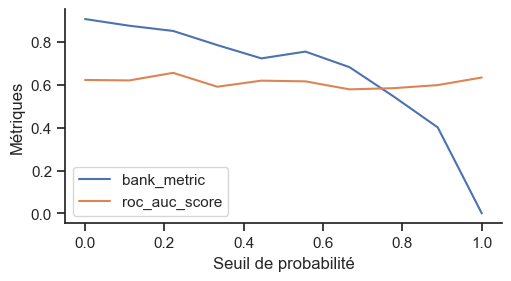

In [379]:
seuil_solvabilité(XGBClass_fine_tuned, X_test, y_test)

In [380]:
from sklearn.metrics import fbeta_score, accuracy_score, precision_score, recall_score, average_precision_score

def prediction_seuil_optimal(model, seuil):
    
    with mlflow.start_run() as run:
        model.fit(X_train, y_train)
        start_train = time()
        y_proba_train = model.predict_proba(X_train)[:, 1]
        end_train = time()
        y_proba_test = model.predict_proba(X_test)[:, 1]
        end_test = time()
        
    print_auto_logged_info(mlflow.get_run(run_id=run.info.run_id))
    mlflow.end_run()
    
    #Seuil de base 0.5 (à optimiser par la suite)
    df_predictions_train = pd.DataFrame()
    df_predictions_train["y_train"] = y_train 
    df_predictions_train['y_proba_train'] = y_proba_train
    y_pred_train = transform_treshold(df_predictions_train["y_proba_train"], seuil)
    df_predictions_train['y_pred_train'] = y_pred_train
   
    # Calculate error metrics
    time_pred_train = end_train - start_train
    auc_train = roc_auc_score(y_train, y_proba_train)
    accuracy_train = accuracy_score(df_predictions_train["y_train"], df_predictions_train["y_pred_train"])
    precision_train = precision_score(df_predictions_train["y_train"], df_predictions_train["y_pred_train"])
    recall_train = recall_score(df_predictions_train["y_train"], df_predictions_train["y_pred_train"])
    bank_train = bank_metric(df_predictions_train["y_train"], df_predictions_train["y_pred_train"])
    
     #Seuil de base 0.5 (à optimiser par la suite)
    df_predictions_test = pd.DataFrame()
    df_predictions_test["y_test"] = y_test 
    df_predictions_test['y_proba_test'] = y_proba_test
    y_pred_test = transform_treshold(df_predictions_test["y_proba_test"], seuil)
    df_predictions_test['y_pred_test'] = y_pred_test
   
    # Calculate error metrics
    time_pred_test = end_test - end_train
    auc_test = roc_auc_score(y_test, y_proba_test)
    accuracy_test = accuracy_score(df_predictions_test["y_test"], df_predictions_test["y_pred_test"])
    precision_test = precision_score(df_predictions_test["y_test"], df_predictions_test["y_pred_test"])
    recall_test = recall_score(df_predictions_test["y_test"], df_predictions_test["y_pred_test"])
    bank_test = bank_metric(df_predictions_test["y_test"], df_predictions_test["y_pred_test"])
    
    print("")
    plot_roc_curve(df_predictions_test['y_test'], df_predictions_test["y_proba_test"])
    #print(f'model 1 AUC score: {roc_auc_score(df_predictions_test['y_test'], df_predictions_test["y_proba_test"])}')
    plt.show()
    
    print("bank_metric =", bank_train, bank_test)
    print ("auc = ", auc_train, auc_test)
    print ("accuracy = ", accuracy_train, accuracy_test)
    print("precision = ", precision_train, precision_test)
    print("recall =", recall_train, recall_test)
    print ("time_pred = ", time_pred_train, time_pred_test)
    print("") 
    
    df_result = pd.DataFrame({
    "data" : ["train", "test"],
    "bank_metric" : [bank_train, bank_test],
    "auc" : [auc_train, auc_test],
    "accuracy" : [accuracy_train, accuracy_test],
    "precision" : [precision_train, precision_test],
    "recall" : [recall_train, recall_test],
    "time_pred" : [time_pred_train, time_pred_test]
    })
    
    metrics = ['bank_metric','auc', 'accuracy', 'precision', 'recall','time_pred']

    custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    sns.set_theme(style="ticks", rc=custom_params)
    fig = plt.figure(figsize=(20,60))

    for i, c in enumerate(metrics,1):
        ax = fig.add_subplot(2,7,i)
        sns.barplot(data=df_result, x="data", y=df_result[c], palette = "Set2")
        plt.xticks(fontsize= 16)
        plt.yticks(fontsize= 14)
        plt.xlabel("", fontsize= 16)
        plt.ylabel(c, fontsize= 16)
        plt.ylim(0, 1) 

    plt.tight_layout(w_pad=2, h_pad=1)
    plt.gcf().set_size_inches(16,7)
    plt.show()
    
    from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
    cm = confusion_matrix(df_predictions_test["y_test"], df_predictions_test["y_pred_test"])
    cm_display = ConfusionMatrixDisplay(cm).plot()
    
    
    return df_predictions_test, df_predictions_train
    

In [ ]:
prediction_seuil_optimal(XGBClass_fine_tuned, 0.25)

2023/12/21 17:11:29 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 17:11:31 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 17:11:31 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 17:11:31 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 17:11:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or 

run_id: da693b78942048adbc2ce69eb5afb745
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/model.xgb', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'base_score': 'None', 'booster': 'None', 'colsample_bylevel': 'None', 'colsample_bynode': 'None', 'colsample_bytree': 'None', 'custom_metric': 'None', 'device': 'None', 'early_stopping_rounds': 'None', 'eval_metric': 'None', 'gamma': 'None', 'grow_policy': 'None', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'interaction_constraints': 'None', 'leaf_size': '30', 'learning_rate': 'None', 'maximize': 'None', 'max_bin': 'None', 'max_cat_threshold': 'None', 'max_cat_to_onehot': 'None', 'max_delta_step': 'None', 'max_depth': 'None', 'max_leaves': 'None', 'memory': 'None', 'metric': 'minkowsk

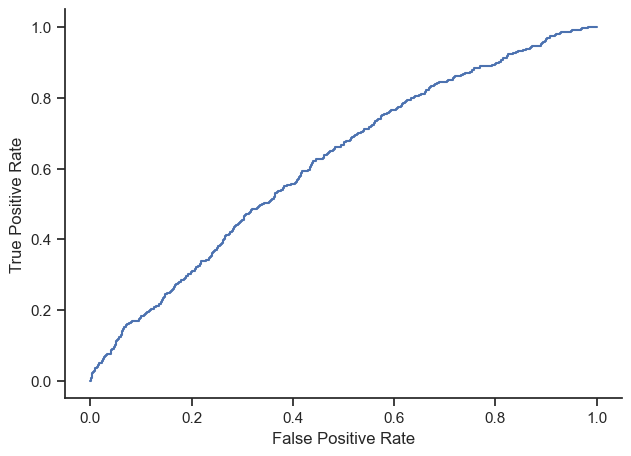

bank_metric = 0.8048104331095793 0.7566401816118048
auc =  0.668158759771735 0.6170857233864298
accuracy =  0.396150484746245 0.39203252032520325
precision =  0.1033465474324698 0.1055350553505535
recall = 0.8634146341463415 0.806390977443609
time_pred =  0.19314885139465332 0.0681905746459961



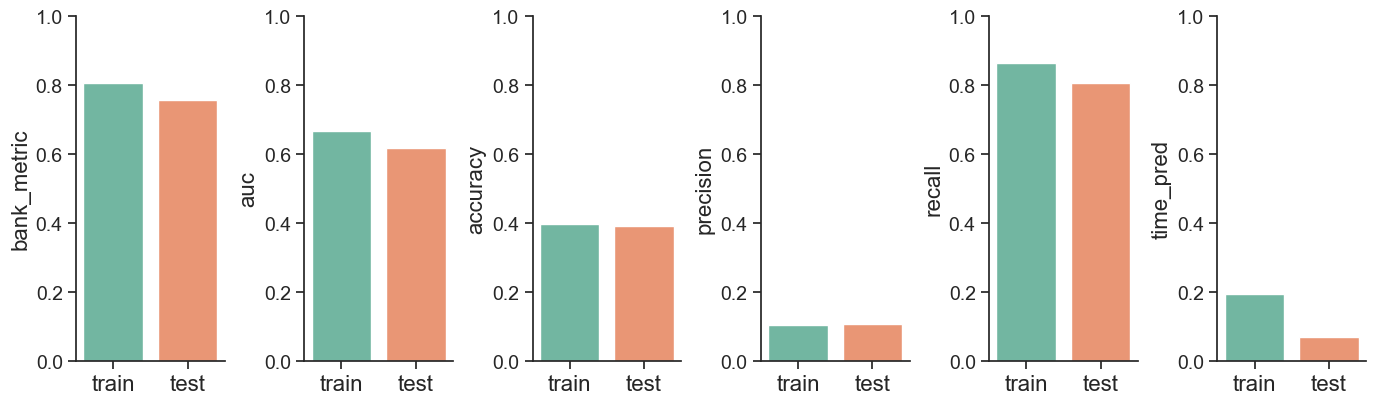

(        y_test  y_proba_test  y_pred_test
 39370        0      0.058764            0
 155080       1      0.228595            0
 18001        0      0.106010            0
 200004       1      0.883917            1
 305910       0      0.850029            1
 ...        ...           ...          ...
 570          0      0.986819            1
 275528       1      0.815448            1
 173778       0      0.983892            1
 301755       0      0.946690            1
 121264       0      0.681920            1
 
 [6150 rows x 3 columns],
         y_train  y_proba_train  y_pred_train
 282535        0       0.937319             1
 180132        0       0.930228             1
 11046         0       0.550621             1
 77297         0       0.245358             0
 140280        0       0.699253             1
 ...         ...            ...           ...
 271443        0       0.909687             1
 209565        0       0.393627             0
 7973          0       0.626368           

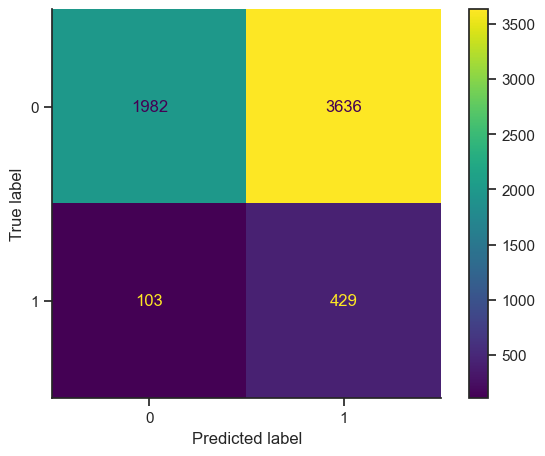

In [438]:
prediction_seuil_optimal(XGBClass_fine_tuned, 0.5)

When to Use ROC vs. Precision-Recall Curves?
Generally, the use of ROC curves and precision-recall curves are as follows:

ROC curves should be used when there are roughly equal numbers of observations for each class.
Precision-Recall curves should be used when there is a moderate to large class imbalance.

# Modèle optimal et conclusions

Le gradient boosting Classifier donne de bons resultats. Sur la base de notre métric banquaire, nous choisissons un seuil strict, à 0.25, qui permet une bonne prédiction des remboursements et (surtout) une très bonne prédiction des défauts de remboursement dans la clientèle d'étude.

Nous allons maintenant nous concentrer sur le dashboard et les informations utiles à afficher pour le client.

In [407]:
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(49201, 10)
(6150, 10)
(6150, 10)


In [439]:
#Model final 
import mlflow

with mlflow.start_run() as run:
    
    XGBClass_fine_tuned.fit(X_train, y_train)
    y_proba = XGBClass_fine_tuned.predict_proba(X_valid)[:, 1]
    df_final = pd.DataFrame()
    df_final["y_valid"] = y_valid
    df_final['y_proba'] = y_proba
    y_pred = transform_treshold(df_final["y_proba"], 0.25)
    df_final['y_pred'] = y_pred

print_auto_logged_info(mlflow.get_run(run_id=run.info.run_id))
mlflow.end_run()

2023/12/21 17:13:23 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


2023/12/21 17:13:25 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 17:13:25 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 17:13:25 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 17:13:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 7fc1d9bc75104fddb081c69871a29695. Failed operations: [MlflowException("Changing pa

run_id: 7fc1d9bc75104fddb081c69871a29695
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/model.xgb', 'model/python_env.yaml', 'model/requirements.txt']
params: {'algorithm': 'auto', 'base_score': 'None', 'booster': 'None', 'colsample_bylevel': 'None', 'colsample_bynode': 'None', 'colsample_bytree': 'None', 'custom_metric': 'None', 'device': 'None', 'early_stopping_rounds': 'None', 'eval_metric': 'None', 'gamma': 'None', 'grow_policy': 'None', 'imputer': "SimpleImputer(strategy='median')", 'imputer__add_indicator': 'False', 'imputer__copy': 'True', 'imputer__fill_value': 'None', 'imputer__keep_empty_features': 'False', 'imputer__missing_values': 'nan', 'imputer__strategy': 'median', 'interaction_constraints': 'None', 'leaf_size': '30', 'learning_rate': 'None', 'maximize': 'None', 'max_bin': 'None', 'max_cat_threshold': 'None', 'max_cat_to_onehot': 'None', 'max_delta_step': 'None', 'max_depth': 'None', 'max_leaves': 'None', 'memory': 'None', 'metric': 'minkowsk

In [440]:
XGBClass_fine_tuned.score(X_valid, y_valid)

0.24959349593495936

In [441]:
X_train.describe()

,DAYS_BIRTH,DAYS_EMPLOYED,CREDIT_TERM,CREDIT_INCOME_PERCENT,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CNT_CHILDREN
count,49201.000000,40221.000000,49200.000000,49201.000000,21441.000000,49089.000000,39413.000000,49201.000000
mean,43.929821,2392.942393,0.053670,3.955313,0.498991,0.515097,0.511752,0.412918
std,11.971315,2357.872454,0.022459,2.686981,0.212541,0.190884,0.193744,0.719264
min,21.021918,2.000000,0.022076,0.076190,0.017394,0.000010,0.000527,0.000000
25%,34.030137,762.000000,0.036736,2.000000,0.328749,0.394890,0.372334,0.000000
50%,43.134247,1646.000000,0.050000,3.250000,0.502401,0.565886,0.537070,0.000000
75%,53.926027,3176.000000,0.063905,5.198000,0.674940,0.663666,0.667458,1.000000
max,69.030137,16632.000000,0.124430,31.462090,0.947649,0.855000,0.893976,19.000000


In [442]:
test = pd.DataFrame(X_valid.dropna(axis=0, how="all"))
test = pd.DataFrame(X_valid.iloc[10]).T
test


,DAYS_BIRTH,DAYS_EMPLOYED,CREDIT_TERM,CREDIT_INCOME_PERCENT,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,ORGANIZATION_TYPE,OCCUPATION_TYPE,CNT_CHILDREN
282986,27.408219,1559.0,0.04884,2.8448,NaN,0.565462,NaN,Construction,Laborers,0


In [443]:
test_json = test.to_json()
print(test_json)

{"DAYS_BIRTH":{"282986":27.4082191781},"DAYS_EMPLOYED":{"282986":1559.0},"CREDIT_TERM":{"282986":0.0488399888},"CREDIT_INCOME_PERCENT":{"282986":2.8448},"EXT_SOURCE_1":{"282986":null},"EXT_SOURCE_2":{"282986":0.5654617863},"EXT_SOURCE_3":{"282986":null},"ORGANIZATION_TYPE":{"282986":"Construction"},"OCCUPATION_TYPE":{"282986":"Laborers"},"CNT_CHILDREN":{"282986":0}}


In [444]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

def predict_bank(X, model):
    
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X)[:, 1]
    y_pred = (y_proba > 0.25).astype("int")
    
    if y_pred == 0:
        print('Client solvable :', "la probabilité de faillite est de",y_proba*100, "%")
    elif y_pred == 1:
        print('Client à risque :', "la probabilité de faillite est de",y_proba*100, "%")
    
    return y_pred

In [445]:
import pickle

# Save to file in the current working directory
pkl_filename = "model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(XGBClass_fine_tuned, file)

# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

In [446]:
##loading the model from the saved file
pkl_filename = "model.pkl"
with open(pkl_filename, 'rb') as f_in:
    model = pickle.load(f_in)

predictValue = predict_bank(test, model)
predictValue

2023/12/21 17:13:33 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'da61be7b21fb4da78ba91016d22c5039', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/12/21 17:13:33 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


2023/12/21 17:13:36 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b7c95f8304a84dd0a6f70ae06429426c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/12/21 17:13:36 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 17:13:36 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 17:13:36 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 17:13:38 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '

Client à risque : la probabilité de faillite est de [92.85327] %


array([1])

# Features importances

1. Que signifie SHAP ?
SHAP signifie SHapley Additive exPlanations et utilise l'approche de la théorie des jeux pour expliquer les prédictions des modèles.
2. Comment fonctionne la bibliothèque SHAP, Quelles sont les valeurs SHAP, Comment les valeurs SHAP sont-elles générées ?
SHAP part d'une valeur de base pour la prédiction, basée sur des connaissances préalables, puis essaie les caractéristiques des données une par une pour comprendre l'impact de l'introduction de cette caractéristique sur notre valeur de base afin d'établir la prédiction finale. Il prend même en compte l'ordre d'introduction des caractéristiques ainsi que l'interaction entre les caractéristiques, ce qui nous aide à mieux comprendre les performances du modèle. Au cours de ce processus, il enregistre les valeurs SHAP qui seront utilisées ultérieurement pour tracer et expliquer les prédictions.
Ces valeurs SHAP sont générées pour chaque caractéristique des données et montrent généralement leur impact sur la prédiction. SHAP possède de nombreux objets explicatifs qui utilisent différentes approches pour générer des valeurs SHAP en fonction de l'algorithme utilisé. Nous les avons énumérés plus loin en donnant quelques explications à leur sujet.
3. Comment interpréter les prédictions à l'aide de SHAP ?
Charger la bibliothèque shap (l'importer et l'initialiser).
Créer un objet Explainer.
Générer des valeurs SHAP pour les exemples de données en utilisant l'objet explainer.
Créer diverses visualisations à l'aide de ces valeurs shap pour expliquer les prédictions.

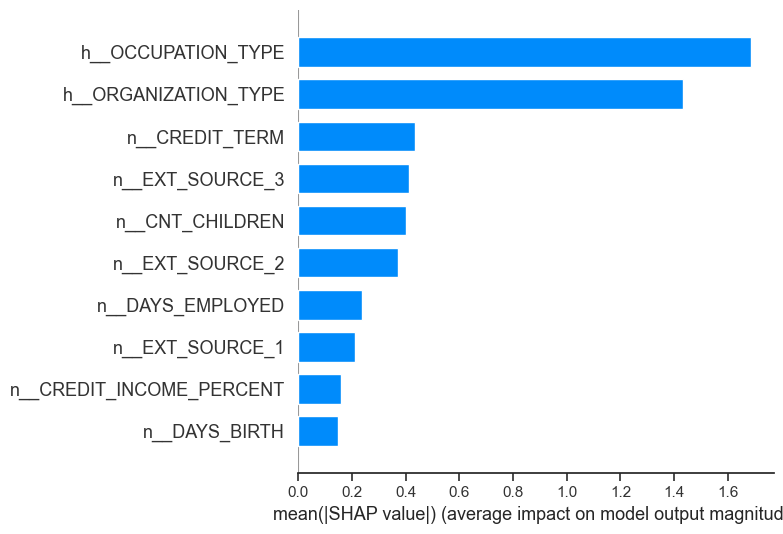

In [447]:
import shap
from shap import TreeExplainer
#set_config(transform_output="pandas")
#load JS vis in the notebook

shap.initjs() 

#set the tree explainer as the model of the pipeline
explainer = shap.TreeExplainer(XGBClass_fine_tuned['model'])

#apply the preprocessing to x_test
observations = XGBClass_fine_tuned['preprocessor'].transform(X_valid)

#get Shap values from preprocessed data
shap_values = explainer.shap_values(observations)

#plot the feature importance
shap.summary_plot(shap_values, observations, plot_type="bar")
#shap.plots.bar(shap_values, max_display=12)

#plot the feature importance
#shap.summary_plot(shap_values[1], observations, plot_type="bar")

Local bar plot
Le passage d'une ligne de valeurs SHAP à la fonction de tracé en barres crée un tracé local de l'importance de l'élément, où les barres représentent les valeurs SHAP pour chaque élément. Notez que les valeurs des features sont affichées en gris à gauche des noms des features.

In [448]:
random_idx = np.random.randint(len(observations))
random_idx

156

In [449]:
X_valid.iloc[random_idx]

DAYS_BIRTH                           35.380822
DAYS_EMPLOYED                           1804.0
CREDIT_TERM                           0.051461
CREDIT_INCOME_PERCENT                     3.49
EXT_SOURCE_1                               NaN
EXT_SOURCE_2                          0.017904
EXT_SOURCE_3                          0.123735
ORGANIZATION_TYPE            Transport: type 3
OCCUPATION_TYPE          High skill tech staff
CNT_CHILDREN                                 3
Name: 249377, dtype: object

In [450]:
shap_explainer_values = explainer(observations, y_valid)
type(shap_explainer_values)

shap._explanation.Explanation

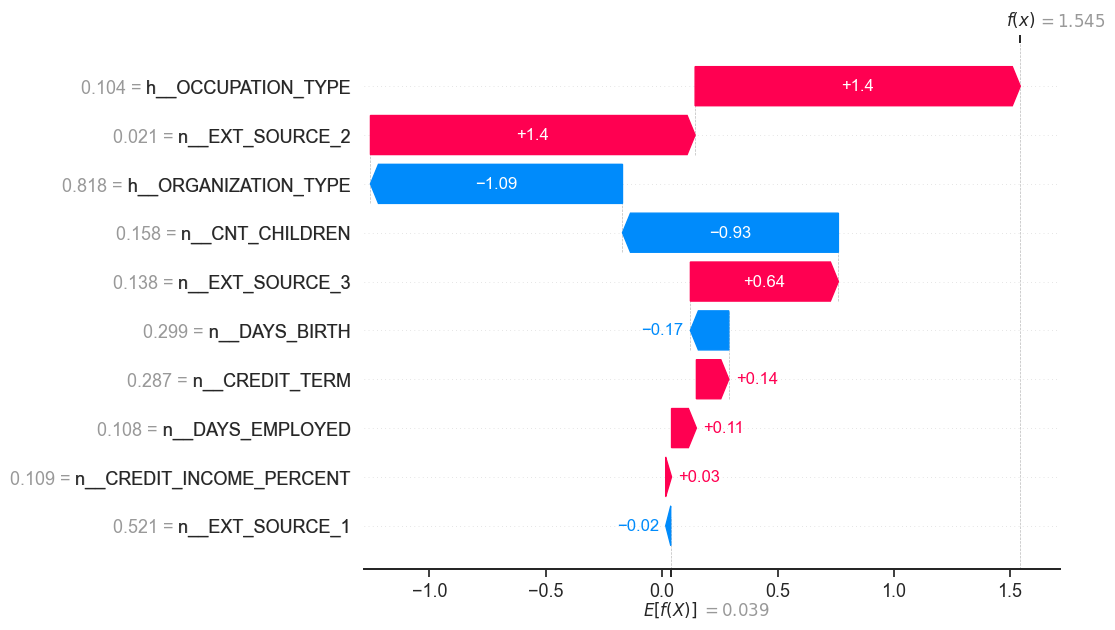

In [451]:
from shap import waterfall_plot

shap.waterfall_plot(shap_explainer_values[random_idx])

# Evaluation du Data drift avec Evidently

Evidently est une bibliothèque Python open-source destinée aux data scientists et aux ingénieurs ML.
Elle permet d'évaluer, de tester et de contrôler les données et les modèles de ML, de la validation à la production. Elle fonctionne avec des données tabulaires, textuelles et des embeddings.

In [452]:
import evidently
from evidently.test_suite import TestSuite
from evidently.test_preset import DataStabilityTestPreset

from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

In [453]:
print(X_train_evidently.shape)
print(X_test_evidently.shape)
print(X_valid_evidently.shape) 

print(y_train_evidently.shape) 
print(y_test_evidently.shape)
print(y_valid_evidently.shape) 

(49201, 12)
(6150, 12)
(6150, 12)
(49201,)
(6150,)
(6150,)


In [454]:
XGBClass_fine_tuned["preprocessor"].fit(X_train_evidently, y_train)

X_train_transf = pd.DataFrame(XGBClass_fine_tuned["preprocessor"].transform(X_train_evidently),
             columns=XGBClass_fine_tuned["preprocessor"].get_feature_names_out(),
             index=X_train_evidently.index)

X_test_transf = pd.DataFrame(XGBClass_fine_tuned["preprocessor"].transform(X_test_evidently),
             columns=XGBClass_fine_tuned["preprocessor"].get_feature_names_out(),
             index=X_test_evidently.index)


2023/12/21 17:13:45 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd96ab77608dc4caa8abc976130bc8e9e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


2023/12/21 17:13:45 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 17:13:47 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'af3a33eabf8d44bfaab53d0116fbf1ec', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/12/21 17:13:47 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 17:13:47 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/12/21 17:13:48 WARNING mlflow.sklearn: Model was missing function: predict. Not logging pyth

In [455]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = X_train_transf
ext_data_corrs = ext_data.corr()
ext_data_corrs

,n__DAYS_BIRTH,n__DAYS_EMPLOYED,n__CREDIT_TERM,n__CREDIT_INCOME_PERCENT,n__EXT_SOURCE_1,n__EXT_SOURCE_2,n__EXT_SOURCE_3,n__CNT_CHILDREN,h__ORGANIZATION_TYPE,h__OCCUPATION_TYPE
n__DAYS_BIRTH,1.000000,0.184778,-0.095797,0.128824,0.365845,0.099685,0.177629,-0.329489,-0.392121,-0.198766
n__DAYS_EMPLOYED,0.184778,1.000000,-0.066150,0.050575,0.135257,0.089382,0.084790,-0.025830,-0.046386,-0.054790
n__CREDIT_TERM,-0.095797,-0.066150,1.000000,-0.524796,-0.070727,-0.041590,0.003450,0.020259,0.045317,0.056647
n__CREDIT_INCOME_PERCENT,0.128824,0.050575,-0.524796,1.000000,0.076585,0.007749,0.087586,-0.020308,-0.082525,-0.043782
n__EXT_SOURCE_1,0.365845,0.135257,-0.070727,0.076585,1.000000,0.140690,0.112369,-0.089432,-0.138081,-0.182145
n__EXT_SOURCE_2,0.099685,0.089382,-0.041590,0.007749,0.140690,1.000000,0.099159,-0.022309,-0.010089,-0.085786
n__EXT_SOURCE_3,0.177629,0.084790,0.003450,0.087586,0.112369,0.099159,1.000000,-0.044400,-0.074602,-0.031930
n__CNT_CHILDREN,-0.329489,-0.025830,0.020259,-0.020308,-0.089432,-0.022309,-0.044400,1.000000,0.138412,0.078345
h__ORGANIZATION_TYPE,-0.392121,-0.046386,0.045317,-0.082525,-0.138081,-0.010089,-0.074602,0.138412,1.000000,0.383375
h__OCCUPATION_TYPE,-0.198766,-0.054790,0.056647,-0.043782,-0.182145,-0.085786,-0.031930,0.078345,0.383375,1.000000


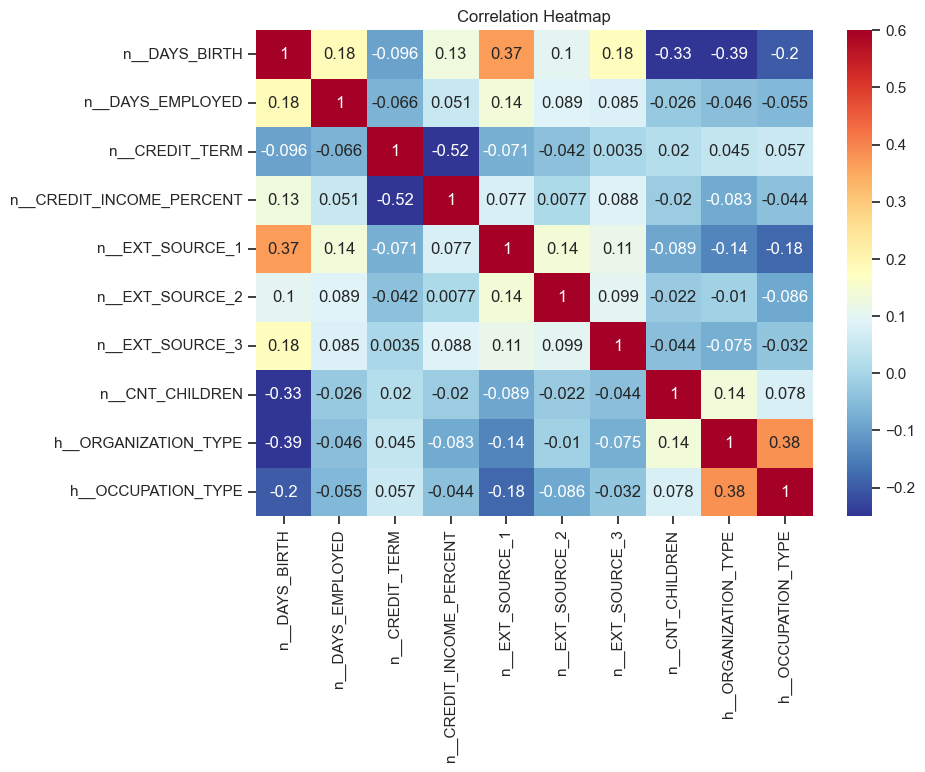

In [456]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

2023/12/21 17:13:50 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'bcd1cd6faad54e8dbabffc4c8c358263', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/12/21 17:13:51 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/12/21 17:13:51 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2023/12/21 17:13:51 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/12/21 17:13:53 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e53729d85c694091a906e18c07fb6f5d', which will track hyperparameters, performance metrics, model

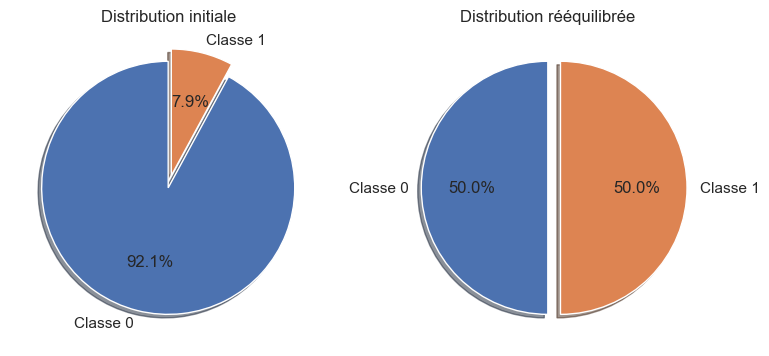

In [457]:
# Réquilibrage de la cible
# Note : sampling_strategy=0.2, the ratio peut-être choisi

from imblearn.over_sampling import SMOTE

X_train_SMOTE, y_train_SMOTE = XGBClass_fine_tuned["over"].fit_resample(X_train_transf, y_train)
X_test_SMOTE, y_test_SMOTE = XGBClass_fine_tuned["over"].fit_resample(X_test_transf, y_test)
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Distribution initiale')
target_count = y_train.value_counts()
plt.pie(target_count,
        explode=[0, 0.1],
        labels=["Classe 0", "Classe 1"],
        autopct='%1.1f%%',
        shadow=True,
        startangle=90)

plt.subplot(122)
plt.title('Distribution rééquilibrée')
target_count = y_train_SMOTE.value_counts()
plt.pie(target_count,
        explode=[0, 0.1],
        labels=["Classe 0", "Classe 1"],
        autopct='%1.1f%%',
        shadow=True,
        startangle=90)

plt.show()

In [458]:
# #Get a report, Get a visual report to explore the feature distribution drift in detail:

# data_drift_report_y = Report(metrics=[
#     DataDriftPreset(),
# ])

# data_drift_report_y.run(current_data=y_test_evidently.sample(frac = 0.1), reference_data=y_train_evidently.sample(frac = 0.1), column_mapping=None)
# data_drift_report_y.save_html("data_drift_report_y.html")
# # lien = file:///C:/Users/camil/Documents/Projet7/data_drift_report_y_valid.html

In [459]:
#Get a report, Get a visual report to explore the feature distribution drift in detail:

data_drift_report = Report(metrics=[
    DataDriftPreset(),
])

data_drift_report.run(current_data=X_test_SMOTE.sample(frac = 0.2), reference_data=X_train_SMOTE.sample(frac = 0.2), column_mapping=None)
data_drift_report.save_html("data_drift_report.html")
# lien = file:///C:/Users/camil/Documents/Projet7/data_drift_report.html

In [460]:
pip freeze > requirements.txt 

Note: you may need to restart the kernel to use updated packages.
